<a href="https://colab.research.google.com/github/jcs-lambda/DS-Unit-2-Applied-Modeling/blob/master/module4-model-interpretation/LS_DS_234_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


Lambda School Data Science

*Unit 2, Sprint 3, Module 4*

---

# Model Interpretation

You will use your portfolio project dataset for all assignments this sprint.

## Assignment

Complete these tasks for your project, and document your work.

- [ ] Continue to iterate on your project: data cleaning, exploratory visualization, feature engineering, modeling.
- [ ] Make at least 1 partial dependence plot to explain your model.
- [ ] Make at least 1 Shapley force plot to explain an individual prediction.
- [ ] **Share at least 1 visualization (of any type) on Slack!**

If you aren't ready to make these plots with your own dataset, you can practice these objectives with any dataset you've worked with previously. Example solutions are available for Partial Dependence Plots with the Tanzania Waterpumps dataset, and Shapley force plots with the Titanic dataset. (These datasets are available in the data directory of this repository.)

Please be aware that **multi-class classification** will result in multiple Partial Dependence Plots (one for each class), and multiple sets of Shapley Values (one for each class).

## Stretch Goals

#### Partial Dependence Plots
- [ ] Make multiple PDPs with 1 feature in isolation.
- [ ] Make multiple PDPs with 2 features in interaction. 
- [ ] Use Plotly to make a 3D PDP.
- [ ] Make PDPs with categorical feature(s). Use Ordinal Encoder, outside of a pipeline, to encode your data first. If there is a natural ordering, then take the time to encode it that way, instead of random integers. Then use the encoded data with pdpbox. Get readable category names on your plot, instead of integer category codes.

#### Shap Values
- [ ] Make Shapley force plots to explain at least 4 individual predictions.
    - If your project is Binary Classification, you can do a True Positive, True Negative, False Positive, False Negative.
    - If your project is Regression, you can do a high prediction with low error, a low prediction with low error, a high prediction with high error, and a low prediction with high error.
- [ ] Use Shapley values to display verbal explanations of individual predictions.
- [ ] Use the SHAP library for other visualization types.

The [SHAP repo](https://github.com/slundberg/shap) has examples for many visualization types, including:

- Force Plot, individual predictions
- Force Plot, multiple predictions
- Dependence Plot
- Summary Plot
- Summary Plot, Bar
- Interaction Values
- Decision Plots

We just did the first type during the lesson. The [Kaggle microcourse](https://www.kaggle.com/dansbecker/advanced-uses-of-shap-values) shows two more. Experiment and see what you can learn!

### Links

#### Partial Dependence Plots
- [Kaggle / Dan Becker: Machine Learning Explainability — Partial Dependence Plots](https://www.kaggle.com/dansbecker/partial-plots)
- [Christoph Molnar: Interpretable Machine Learning — Partial Dependence Plots](https://christophm.github.io/interpretable-ml-book/pdp.html) + [animated explanation](https://twitter.com/ChristophMolnar/status/1066398522608635904)
- [pdpbox repo](https://github.com/SauceCat/PDPbox) & [docs](https://pdpbox.readthedocs.io/en/latest/)
- [Plotly: 3D PDP example](https://plot.ly/scikit-learn/plot-partial-dependence/#partial-dependence-of-house-value-on-median-age-and-average-occupancy)

#### Shapley Values
- [Kaggle / Dan Becker: Machine Learning Explainability — SHAP Values](https://www.kaggle.com/learn/machine-learning-explainability)
- [Christoph Molnar: Interpretable Machine Learning — Shapley Values](https://christophm.github.io/interpretable-ml-book/shapley.html)
- [SHAP repo](https://github.com/slundberg/shap) & [docs](https://shap.readthedocs.io/en/latest/)

In [1]:
%matplotlib inline

!pip install -U --quiet pandas-profiling category_encoders eli5 pdpbox shap

import pandas as pd
import numpy as np
import sqlite3 as sql
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import category_encoders as ce

import pandas_profiling
import eli5
import graphviz

from xgboost import XGBClassifier
from eli5.sklearn import PermutationImportance
from IPython.display import display, HTML
from google.colab import drive
from IPython.display import display, HTML

drive.mount('drive')

random_state = 13

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning:

The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning:

The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.

Using TensorFlow backend.


Drive already mounted at drive; to attempt to forcibly remount, call drive.mount("drive", force_remount=True).


In [2]:
def group_syllables(syllables):
  if syllables <= 2:
    return '1-2'
  elif syllables <= 5:
    return '3-5'
  else:
    return '6+'

db_file = '/content/drive/My Drive/android-21-12-primary.sqlite'
conn = sql.connect(db_file)

df_entries = pd.read_sql_query('SELECT entry, entry_rich FROM entries', conn)
print(f'entries: {df_entries.shape}')

# select entries that only contain letters and have at least 3 characters
df_words = df_entries[df_entries['entry'].str.match('^[a-z]{3,}$', case=False)].copy()

# drop entries with no vowels or y's
no_vowelys = ~df_words['entry'].str.contains('[aeiouy]')
df_words.drop(no_vowelys[no_vowelys == True].index, inplace=True)

# fix some errors i found
df_words.loc[df_words['entry']=='finasteride', 'entry_rich'] = chr(183).join(['fin', 'as', 'ter', 'ide'])
df_words.loc[df_words['entry']=='subnuclear', 'entry_rich'] = chr(183).join(['sub', 'nu', 'cle', 'ar'])
df_words.loc[df_words['entry']=='omeprazole', 'entry_rich'] = chr(183).join(['o', 'me', 'pra', 'zole'])
df_words.loc[df_words['entry']=='protocal', 'entry_rich'] = chr(183).join(['pro', 'to', 'cal'])

# create feature 'syllables'
df_words['syllables'] = df_words['entry_rich'].str.split(chr(183)).str.len()

# drop words with more than 10 syllables (only a few of each, tends to skew the models)
df_words = df_words[df_words['syllables'] <= 10].copy()

# create feature 'syllables_group'
df_words['syllables_group'] = df_words['syllables'].apply(group_syllables)

# create feature 'length'
df_words['length'] = df_words['entry'].str.len()

# create vowel related features
#  'num_vowels' - total occurences of 'a', 'e', 'i', 'o', and 'u'
#  'vowel_chunks' - total occurences of sequential vowels (includes y)
#  'max_vowel_chunk_length' - length of longest vowel sequence
#  'ends_with_e' - last letter is 'e'
#  'h_as_vowel' - 'h' is used as part of a vowel sound ('h' is preceded by a vowel and followed by a consonant)
df_words['num_vowels'] = df_words['entry'].str.count('[aeiou]')
df_words['vowel_chunks'] = df_words['entry'].str.count('[aeiouy]')
df_words['max_vowel_chunk_length'] = df_words['entry'].str.split('[^aeiouy]+').apply(lambda a_list : max([len(item) for item in a_list]))
df_words['ends_with_e'] = df_words['entry'].str.endswith('e')
df_words['h_as_vowel'] = df_words['entry'].str.contains('[aeiou]h[^aeiouy]')

# create features to account for the character 'y'
#  'num_ys' - total occurences of 'y'
#  'ends_with_y' - ends with 'y'
#  'y_as_consonant' - a 'y' is surrounded by vowels, and is most likely a consonant in this context
df_words['num_ys'] = df_words['entry'].str.count('y')
df_words['ends_with_y'] = df_words['entry'].str.endswith('y')
df_words['y_as_consonant'] = df_words['entry'].str.contains('[aeiou]y[aeiou]')

# create features accounting for consonants
#  'num_consonants' - total occurences of not 'a', 'e', 'i', 'o', and 'u'
#  'consonant_chunks' - total occurences of sequential consonants (excludes y)
#  'max_consonant_chunk_length' - length of longest consonant sequence
#  'num_doubled_consonants' - count of occurrences of doubled consonants ('bb', 'tt', 'ss', 'gg', etc) that are not at the end of a word
df_words['num_consonants'] = df_words['entry'].str.count('[^aeiou]')
df_words['consonant_chunks'] = df_words['entry'].str.count('[^aeiouy]+')
df_words['max_consonant_chunk_length'] = df_words['entry'].str.split('[aeiouy]+').apply(lambda a_list : max([len(item) for item in a_list]))
df_words['num_doubled_consonants'] = df_words['entry'].str.count('([^aeiou])\\1{1}[^$]')

display(df_words.head())
df_words.shape

entries: (148619, 2)


entry  entry_rich  ...  max_consonant_chunk_length num_doubled_consonants
42    Aachen     Aa·chen  ...                           2                      0
49       aah         aah  ...                           1                      0
50   Aalborg    Aal·borg  ...                           2                      0
51  Aalesund  Aa·le·sund  ...                           2                      0
52     aalii     aa·li·i  ...                           1                      0

[5 rows x 17 columns]

(92398, 17)

In [3]:
# function to make a dataframe to predict an arbitrary word
def engineer_word_features(word):
  word = pd.Series(word)
  data = {
      'length' : word.str.len(),
      'num_vowels' : word.str.count('[aeiou]'),
      'vowel_chunks' : word.str.count('[aeiou]+'),
      'max_vowel_chunk_length' : word.str.split('[^aeiou]+').apply(lambda a_list : max([len(item) for item in a_list])),
      'ends_with_e' : word.str.endswith('e'),
      'h_as_vowel' : word.str.contains('[aeiou]h[^aeiouy]'),
      'num_ys' : word.str.count('y'), 
      'ends_with_y' : word.str.endswith('y'),
      'y_as_consonant' : word.str.contains('[aeiou]y[aeiou]'),
      'num_consonants' : word.str.count('[^aeiou]'), 
      'consonant_chunks' : word.str.count('[^aeiou]+'),
      'max_consonant_chunk_length' : word.str.split('[aeiou]+').apply(lambda a_list : max([len(item) for item in a_list])),
      'num_doubled_consonants' : word.str.count('([^aeiou])\\1{1}[^$]')
  }
  df = pd.DataFrame(data)
  df.index = word
  return df

engineer_word_features(['rotund', 'disarticulate', 'schmoozed', 'data', 'date', 'yesterday', 'trying'])

length  ...  num_doubled_consonants
rotund              6  ...                       0
disarticulate      13  ...                       0
schmoozed           9  ...                       0
data                4  ...                       0
date                4  ...                       0
yesterday           9  ...                       0
trying              6  ...                       0

[7 rows x 13 columns]

In [4]:
features_to_drop = ['entry', 'entry_rich', 'syllables', 'syllables_group']

target1 = 'syllables'
target2 = 'syllables_group'

features = df_words.columns.drop(features_to_drop, errors='ignore')
features.tolist()

['length',
 'num_vowels',
 'vowel_chunks',
 'max_vowel_chunk_length',
 'ends_with_e',
 'h_as_vowel',
 'num_ys',
 'ends_with_y',
 'y_as_consonant',
 'num_consonants',
 'consonant_chunks',
 'max_consonant_chunk_length',
 'num_doubled_consonants']

In [5]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df_words, test_size=0.2, random_state=random_state, stratify=df_words[target1])
df_train.shape, df_test.shape

((73918, 17), (18480, 17))

In [0]:
X_train = df_train[features]
X_test = df_test[features]

y1_train = df_train[target1]
y2_train = df_train[target2]
y1_test = df_test[target1]
y2_test = df_test[target2]

In [7]:
def my_value_counts(dataframe, features):
  if type(features) is not list:
    features = [features]
  for feature in features:
    df = pd.DataFrame({
        'count' : dataframe[feature].value_counts().sort_index(),
        'percentage' : dataframe[feature].value_counts(normalize=True).sort_index()
    })
    df.index.name = feature
    display(df.sort_values(by='count', ascending=False))

my_value_counts(df_train, [target1, target2])

count  percentage
syllables                   
2          26462    0.357991
3          21241    0.287359
4          11949    0.161652
1           7638    0.103331
5           4825    0.065275
6           1338    0.018101
7            355    0.004803
8             84    0.001136
9             18    0.000244
10             8    0.000108

count  percentage
syllables_group                   
3-5              38015    0.514286
1-2              34100    0.461322
6+                1803    0.024392

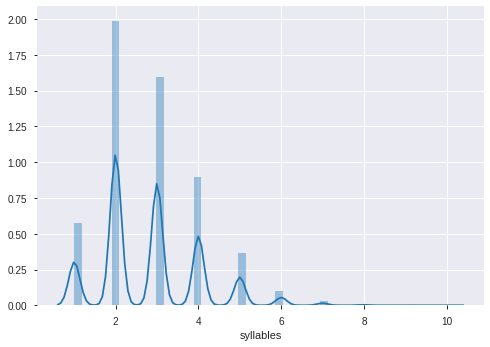

In [8]:
sns.distplot(y1_train);

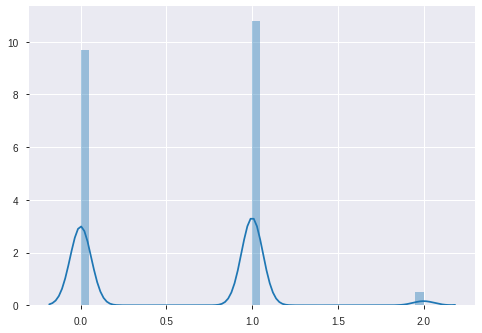

In [9]:
sns.distplot(y2_train.astype('category').cat.codes);

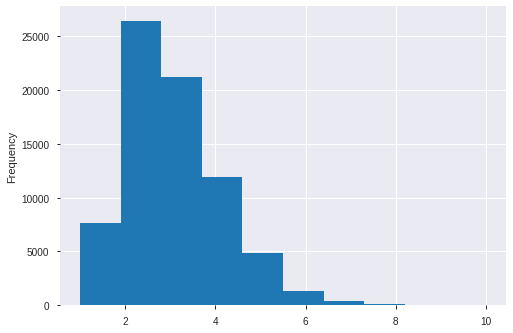

In [10]:
y1_train.plot.hist();

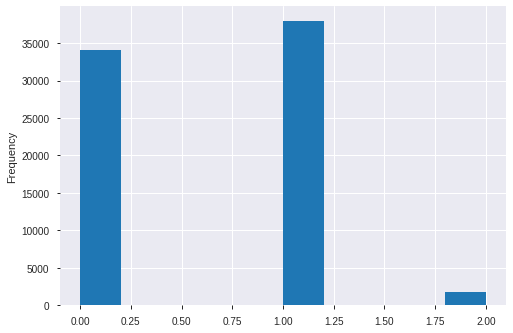

In [11]:
y2_train.astype('category').cat.codes.plot.hist()

In [0]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats.distributions import randint, uniform
from sklearn.metrics import accuracy_score

In [13]:
param_distributions = {
    'n_estimators' : randint(50, 500),
    'criterion' : ['gini', 'entropy'],    
    'max_depth' : [5, 10, 25, 50, 100, None],
    'min_samples_split' : randint(2, 25),
    'min_samples_leaf' : randint(1, 25),
    'max_features' : uniform(0, 1)
}

search = RandomizedSearchCV(
    estimator = RandomForestClassifier(random_state=random_state, n_jobs=-1),
    param_distributions = param_distributions,
    n_iter = 25,
    scoring = 'accuracy',
    n_jobs = -1,
    cv = 3,
    verbose = 10,
    random_state = random_state
).fit(X_train, y1_train)

Fitting 3 folds for each of 25 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    8.8s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   35.8s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:  5.8min
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.

[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:  6.6min finished


In [14]:
print(f'Best score: {search.best_score_ * 100:.2f}%')
print(f'with parameters: {search.best_params_}')
model = search.best_estimator_

Best score: 81.27%
with parameters: {'criterion': 'gini', 'max_depth': 100, 'max_features': 0.6181132100183178, 'min_samples_leaf': 6, 'min_samples_split': 2, 'n_estimators': 135}


In [15]:
y_pred = model.predict(X_test)

print(f'Best RandomForestClassifier test score: {accuracy_score(y1_test, y_pred)*100:.2f}%')

Best RandomForestClassifier test score: 81.65%


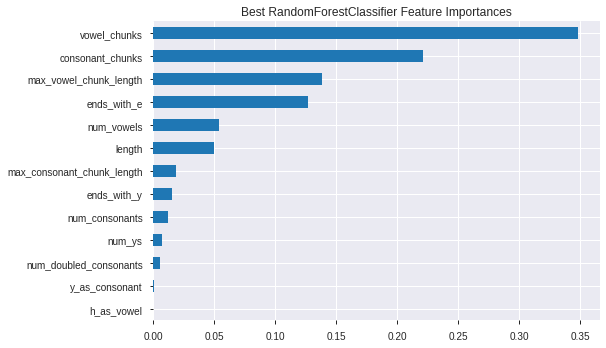

In [16]:
importances = pd.Series(model.feature_importances_, features)
importances.sort_values().plot.barh()
plt.title('Best RandomForestClassifier Feature Importances')
plt.show()

In [17]:
permuter = PermutationImportance(
    estimator=model, 
    scoring='accuracy', 
    n_iter=7, 
    random_state=random_state
)

eli5.show_weights(
    permuter.fit(X_test, y1_test),
    top = None,
    feature_names = features.tolist()
)

In [18]:
permuted_importances = pd.DataFrame({
    'feature' : features,
    'weight' : permuter.feature_importances_,
    'std_err' : permuter.feature_importances_std_
})
permuted_importances['gt_half_pct'] = permuted_importances['weight'] - permuted_importances['std_err'] > 0.005
permuted_importances.sort_values(by=['weight', 'std_err'], ascending=False)

feature    weight   std_err  gt_half_pct
2                 vowel_chunks  0.466945  0.001909         True
10            consonant_chunks  0.195903  0.002522         True
3       max_vowel_chunk_length  0.147820  0.001652         True
4                  ends_with_e  0.116095  0.001689         True
11  max_consonant_chunk_length  0.014054  0.000620         True
1                   num_vowels  0.007560  0.000705         True
7                  ends_with_y  0.004174  0.000223        False
0                       length  0.002427  0.000768        False
9               num_consonants  0.002041  0.000735        False
12      num_doubled_consonants  0.001909  0.000418        False
6                       num_ys  0.001453  0.000323        False
8               y_as_consonant  0.000325  0.000058        False
5                   h_as_vowel  0.000000  0.000000        False

### rabbit trails

In [19]:
model.predict(engineer_word_features(['wonderfully', 'ghost']))

array([3, 1])

In [20]:
w = pd.Series('wonderfully')
w.str.count('([^aeiouy])\\1{1}')

0    1
dtype: int64

In [21]:
import re
re.findall('([^aeiouy])\\1', 'wond\1erfully')

['l']

In [22]:
df_words[df_words['entry'].str.count('([^aeiouy])\\1{1}') > 2]

entry  ... num_doubled_consonants
16654      immunosuppress  ...                      2
16655   immunosuppression  ...                      3
16656   immunosuppressive  ...                      3
34147        Merrillville  ...                      3
36164         Mississippi  ...                      3
36165       Mississippian  ...                      3
64897        Russellville  ...                      3
112786       Burrillville  ...                      3
114704        cappelletti  ...                      3
122821      Connellsville  ...                      3

[10 rows x 17 columns]

In [23]:
df_words[df_words['entry'].str.count('([^aeiouy])\\1{1}[^$]') >2]

entry  ... num_doubled_consonants
16655   immunosuppression  ...                      3
16656   immunosuppressive  ...                      3
34147        Merrillville  ...                      3
36164         Mississippi  ...                      3
36165       Mississippian  ...                      3
64897        Russellville  ...                      3
112786       Burrillville  ...                      3
114704        cappelletti  ...                      3
122821      Connellsville  ...                      3

[9 rows x 17 columns]

In [24]:
df_words[df_words['entry'].str.contains('yy')]

entry entry_rich  ...  max_consonant_chunk_length num_doubled_consonants
44130  Omayyad  O·may·yad  ...                           2                      1
52343   Piyyut    Piy·yut  ...                           1                      1
66703   sayyid    say·yid  ...                           1                      1
95322  Umayyad  U·may·yad  ...                           2                      1

[4 rows x 17 columns]

In [25]:
model.predict(engineer_word_features(['Omayyad', 'Piyyut', 'sayyid', 'Umayyad']))

array([2, 2, 2, 2])

In [26]:
qq = df_words[df_words['entry'].str.contains('[aeiou]y[aeiou]')]
qq

entry  ... num_doubled_consonants
135        abaya  ...                      0
242     abeyance  ...                      0
243      abeyant  ...                      0
2313    affrayer  ...                      1
2823    Ahmadiya  ...                      0
...          ...  ...                    ...
147296     gayal  ...                      0
147298   gayatri  ...                      0
147300    gayety  ...                      0
147311  Gayomart  ...                      0
147459   Gemayel  ...                      0

[542 rows x 17 columns]

In [27]:
qq['pred'] = model.predict(engineer_word_features(qq['entry']))
qq[['entry', 'syllables', 'pred']][qq['syllables'] != qq['pred']]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



entry  syllables  pred
2823        Ahmadiya          4     3
3647         aleyard          2     3
5455           Anaya          3     2
5579        Andreyev          3     2
7861       graveyard          2     3
...              ...        ...   ...
141059  Fayetteville          3     4
141182       fedayee          3     2
144329      foreyard          2     3
146144   funemployed          3     4
147300        gayety          3     2

[147 rows x 3 columns]

In [28]:
df_words[df_words['entry'].str.contains('[aeiou]h[^aeiouy]')]

entry  ... num_doubled_consonants
345         abohm  ...                      0
581        Abwehr  ...                      0
2803       ahchoo  ...                      0
2820        ahkio  ...                      0
9679         Hahn  ...                      0
...           ...  ...                    ...
145928    Fuehrer  ...                      0
146491    gahnite  ...                      0
147407  gehlenite  ...                      0
147408     Gehrig  ...                      0
147409      Gehry  ...                      0

[183 rows x 17 columns]

### back to the assignment

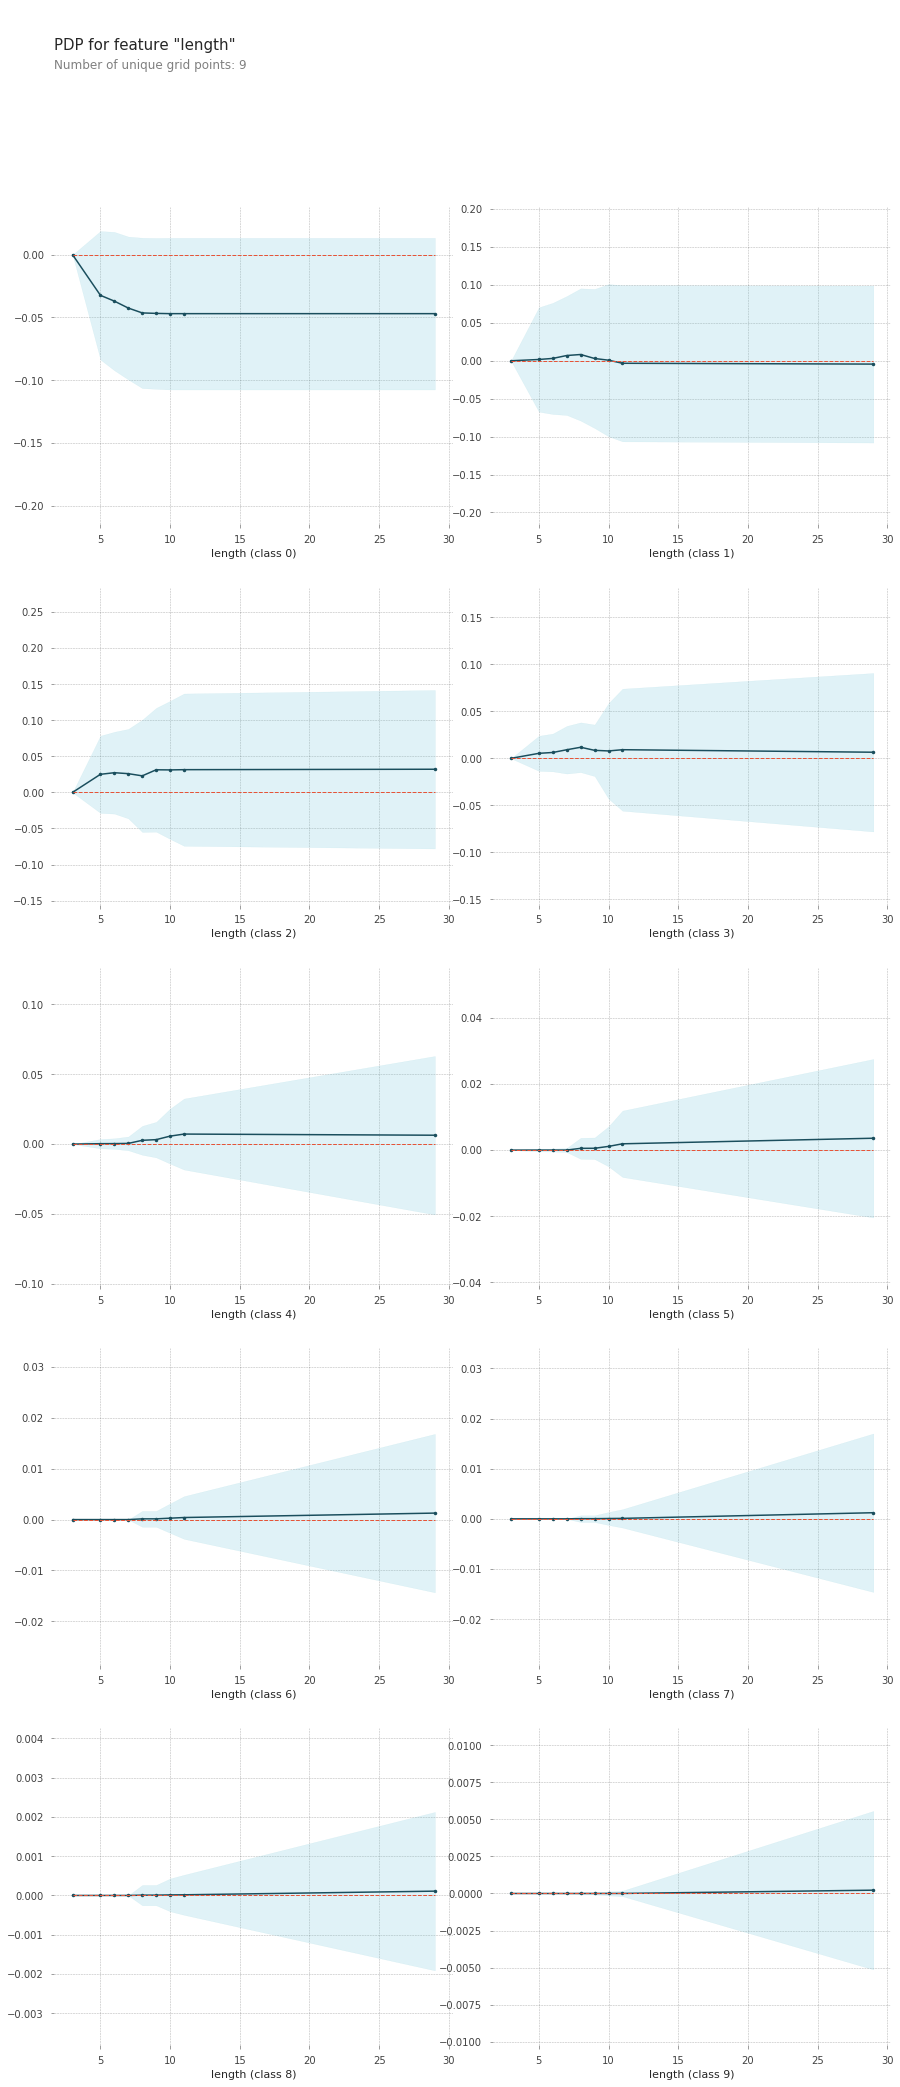

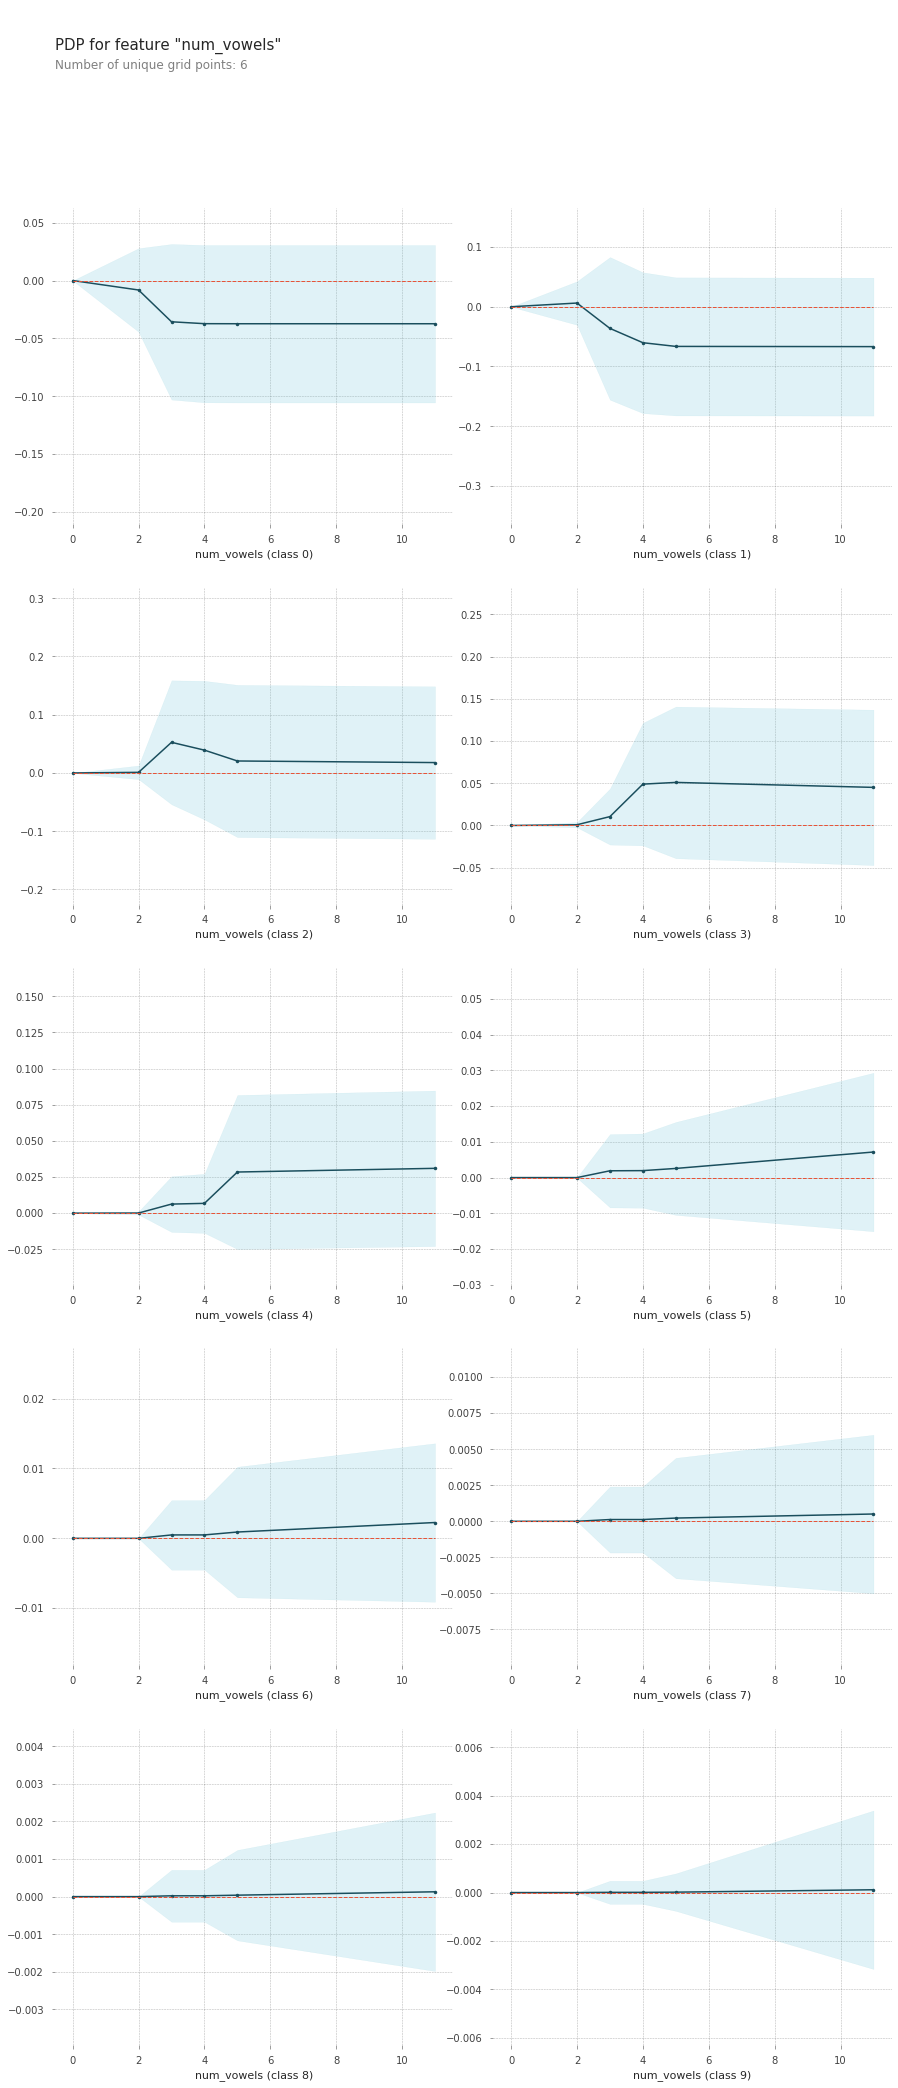

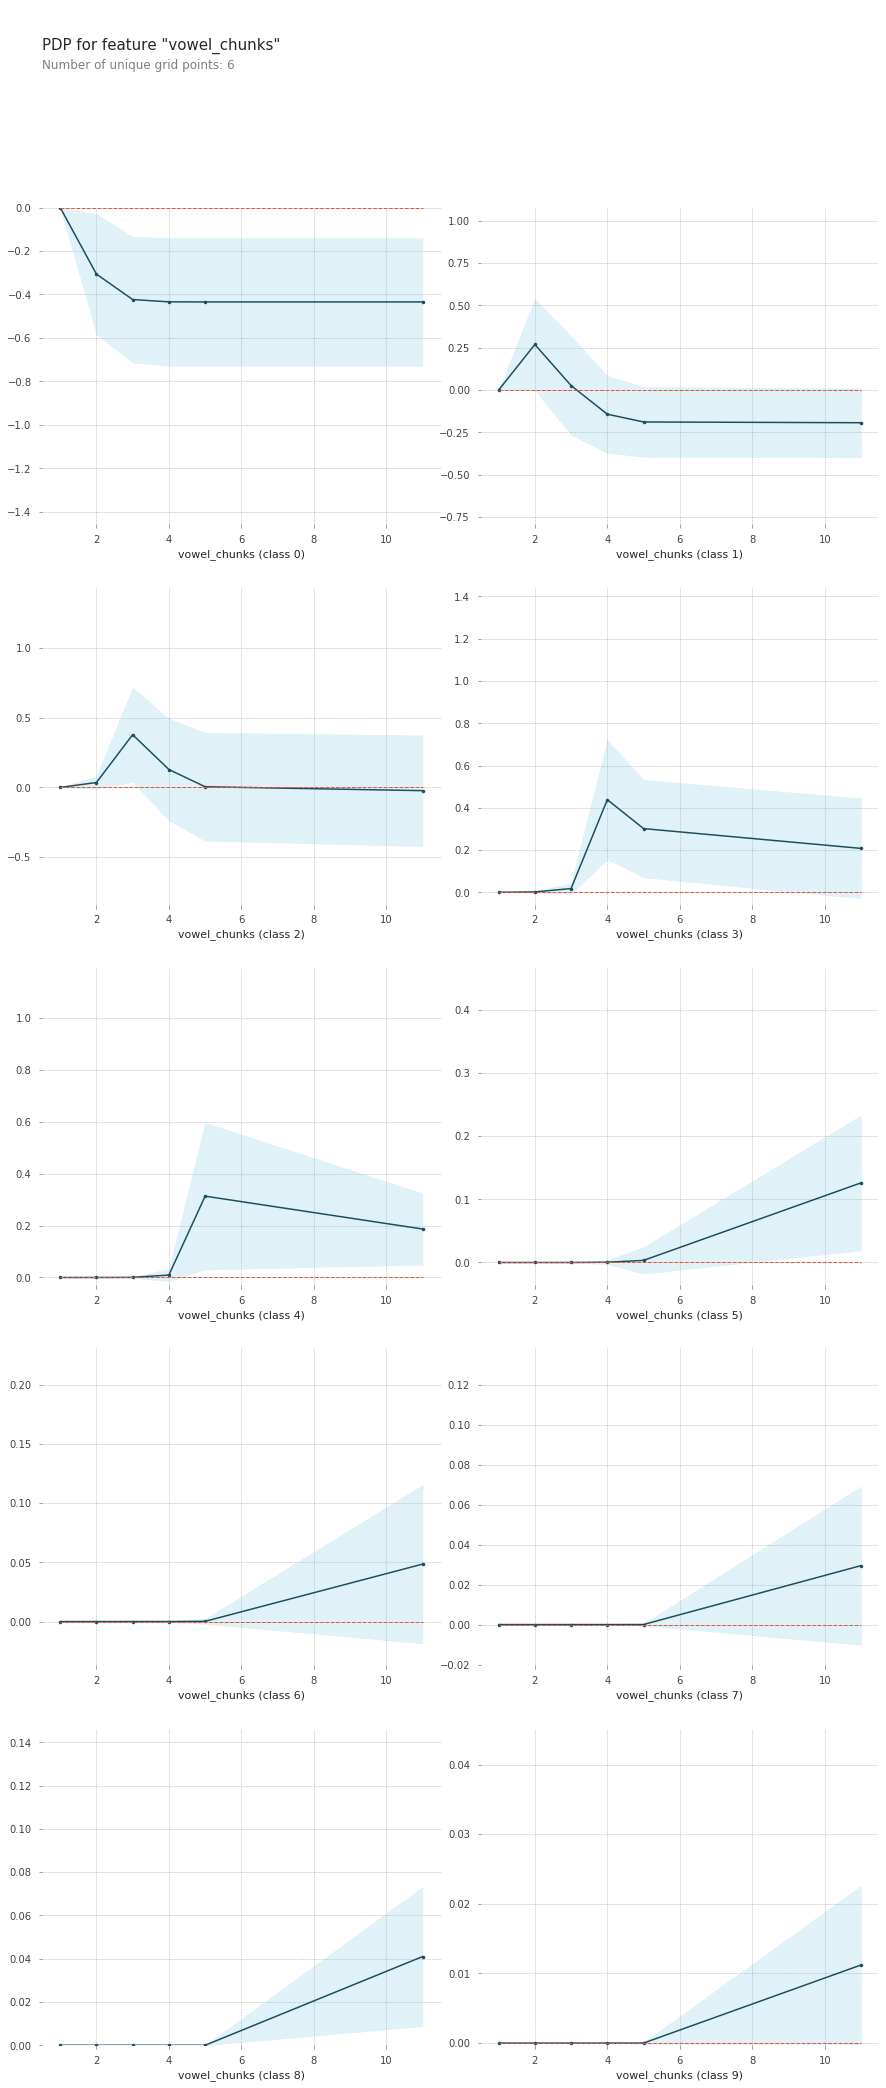

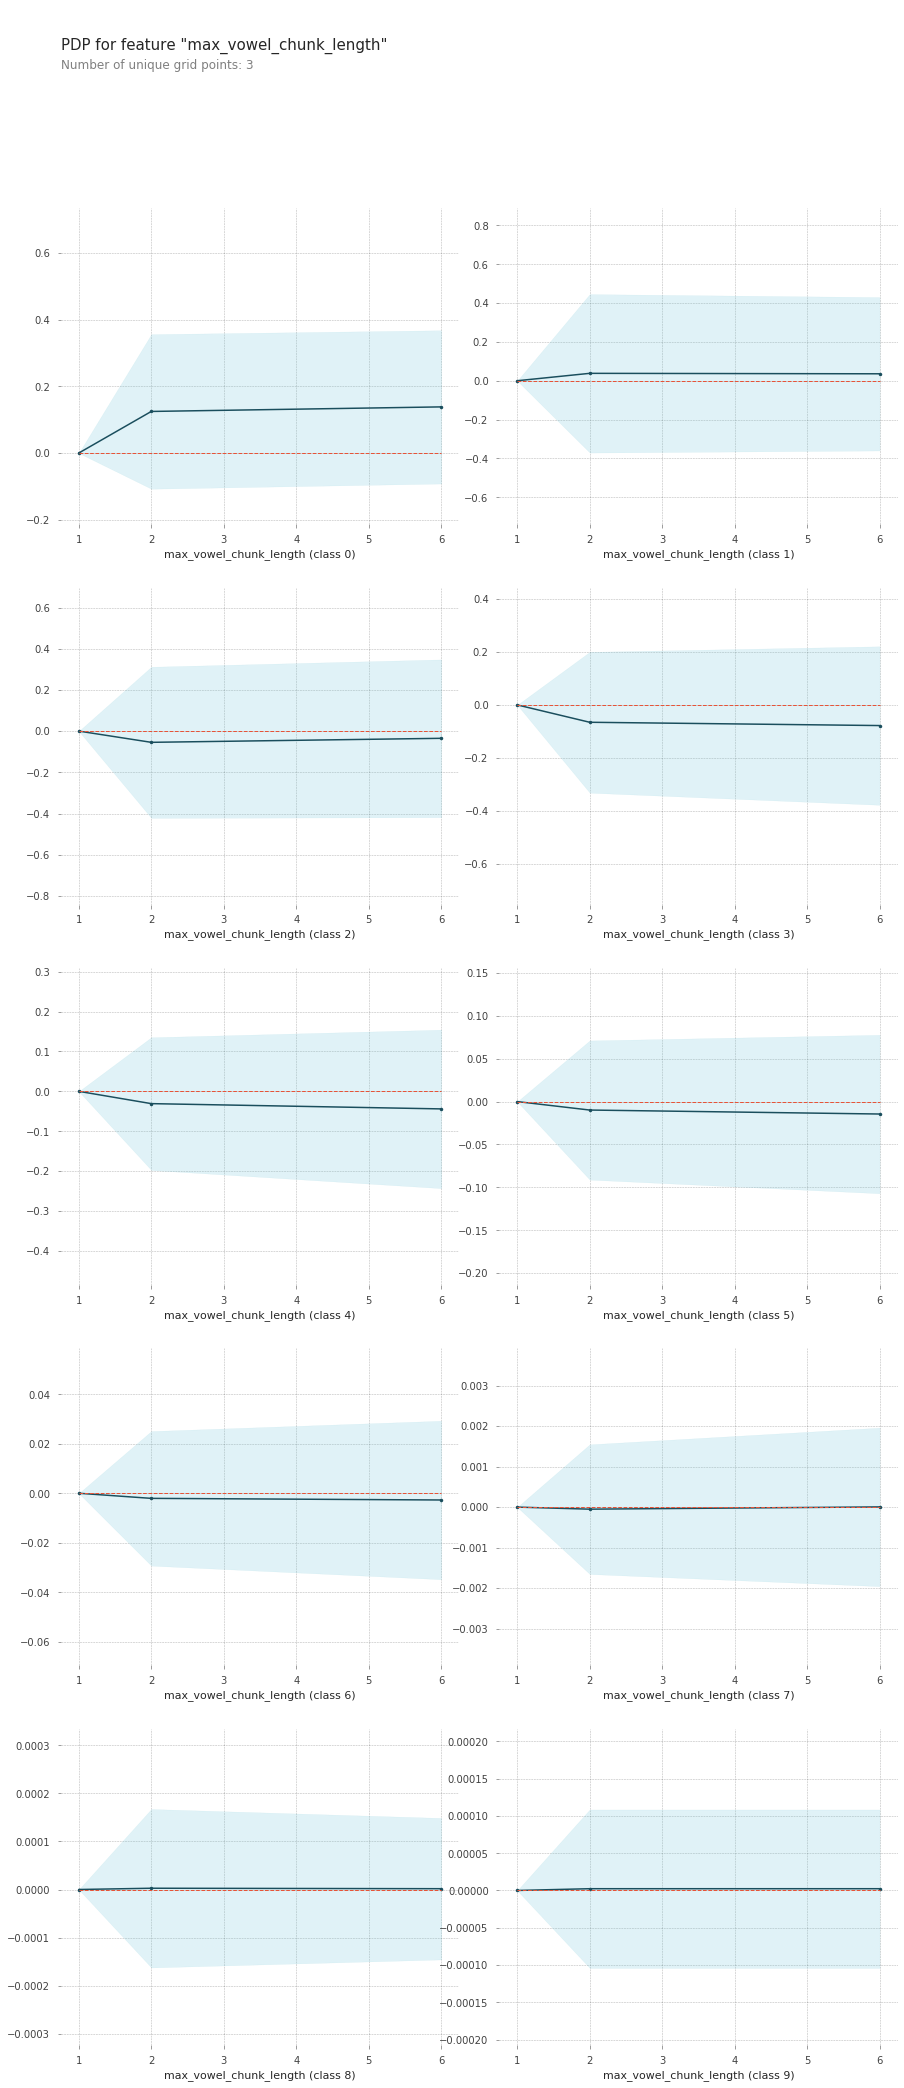

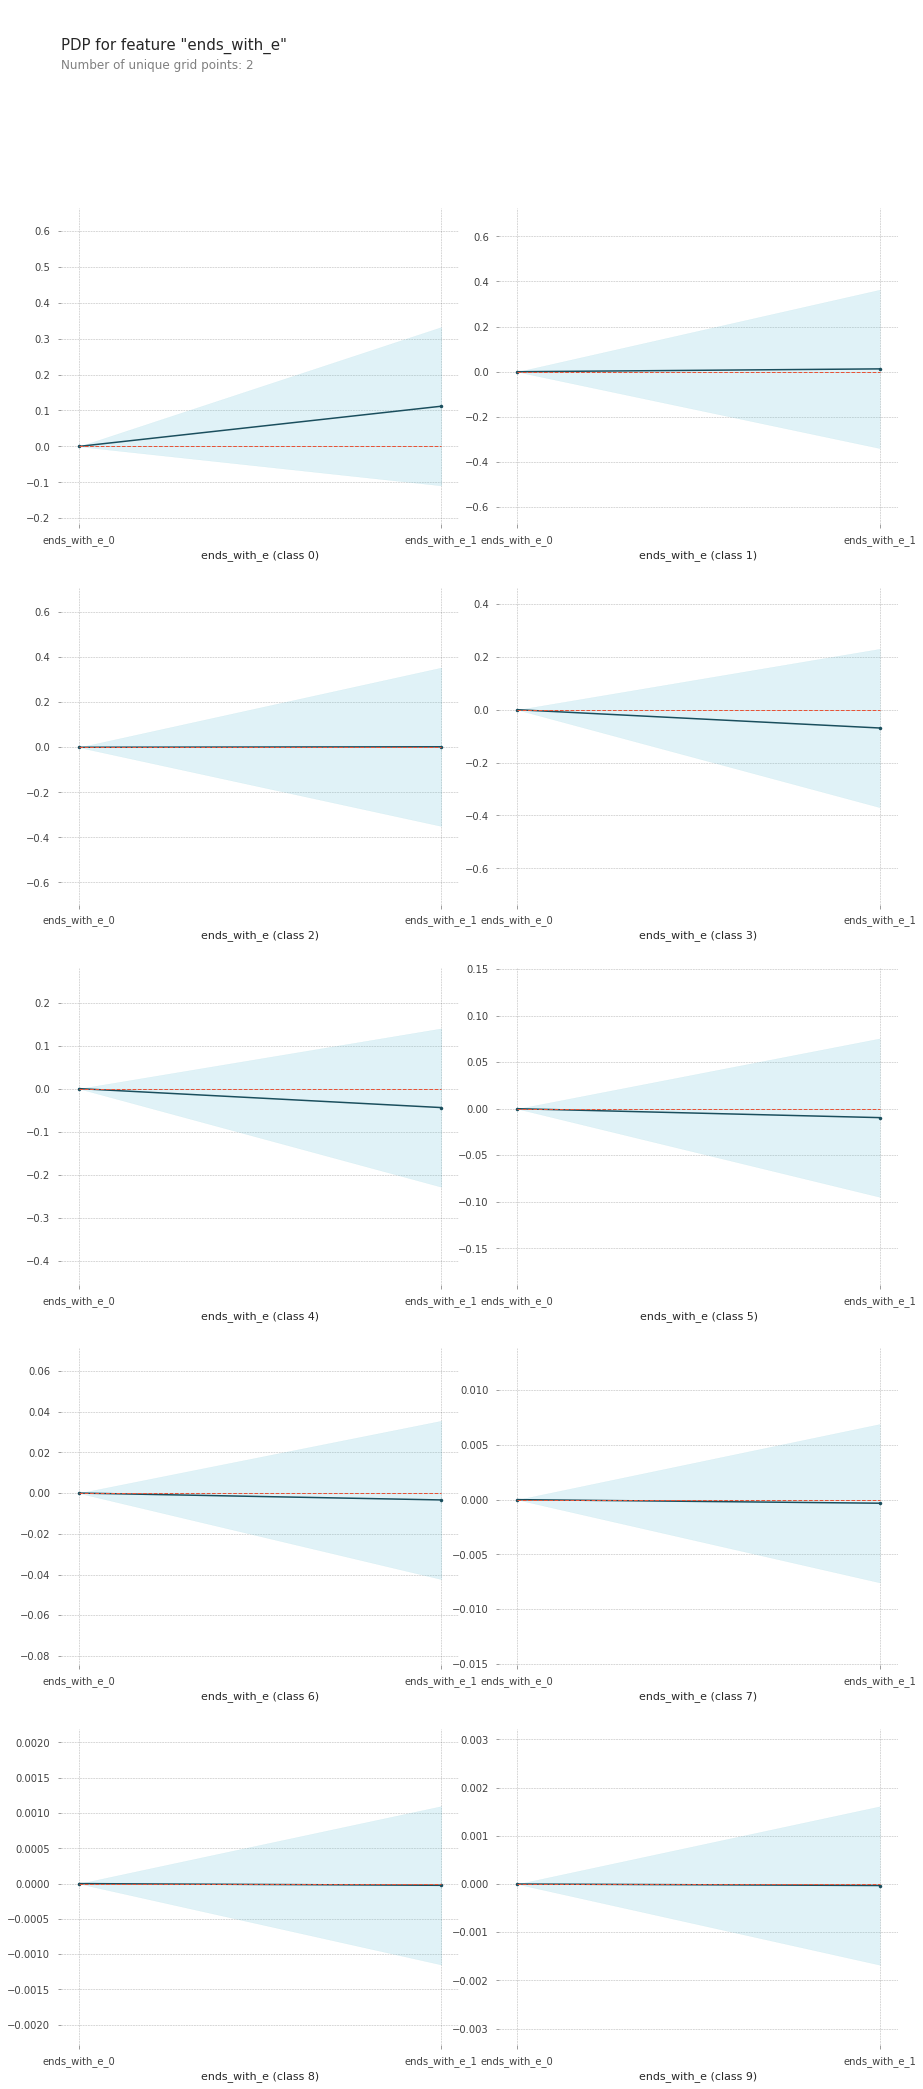

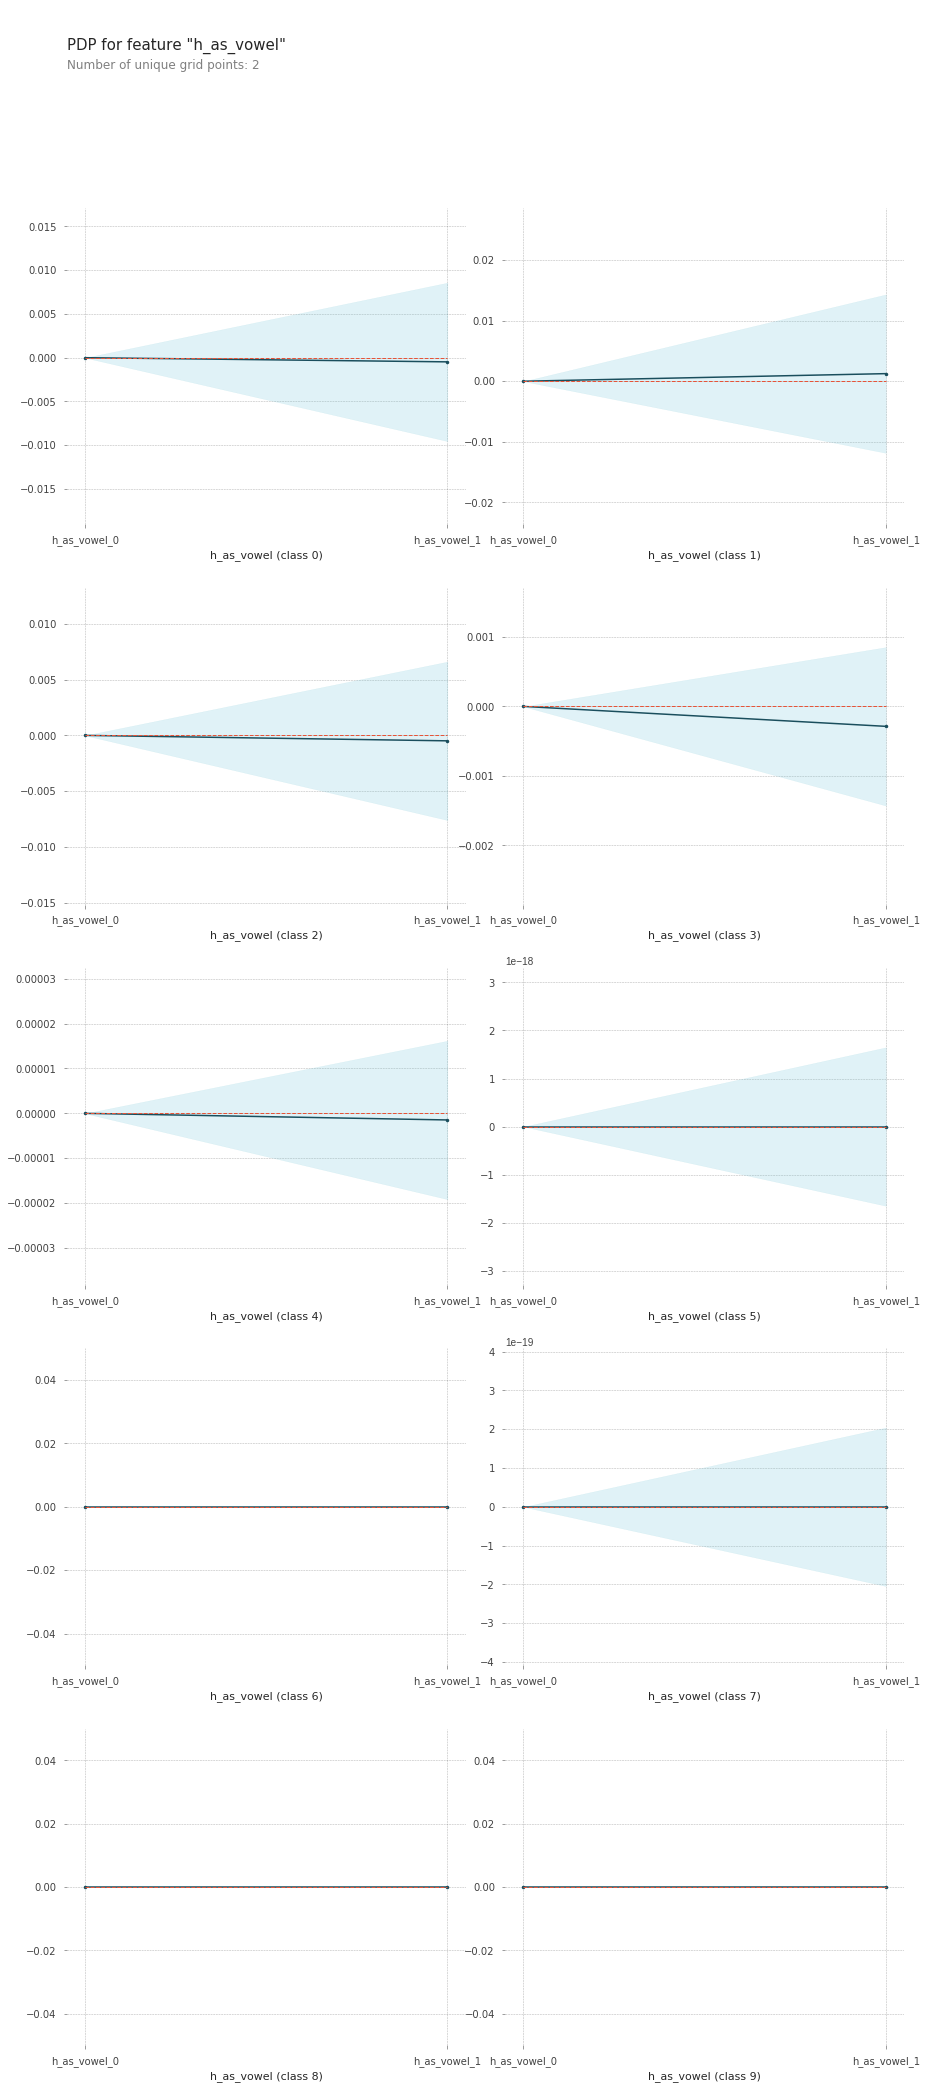

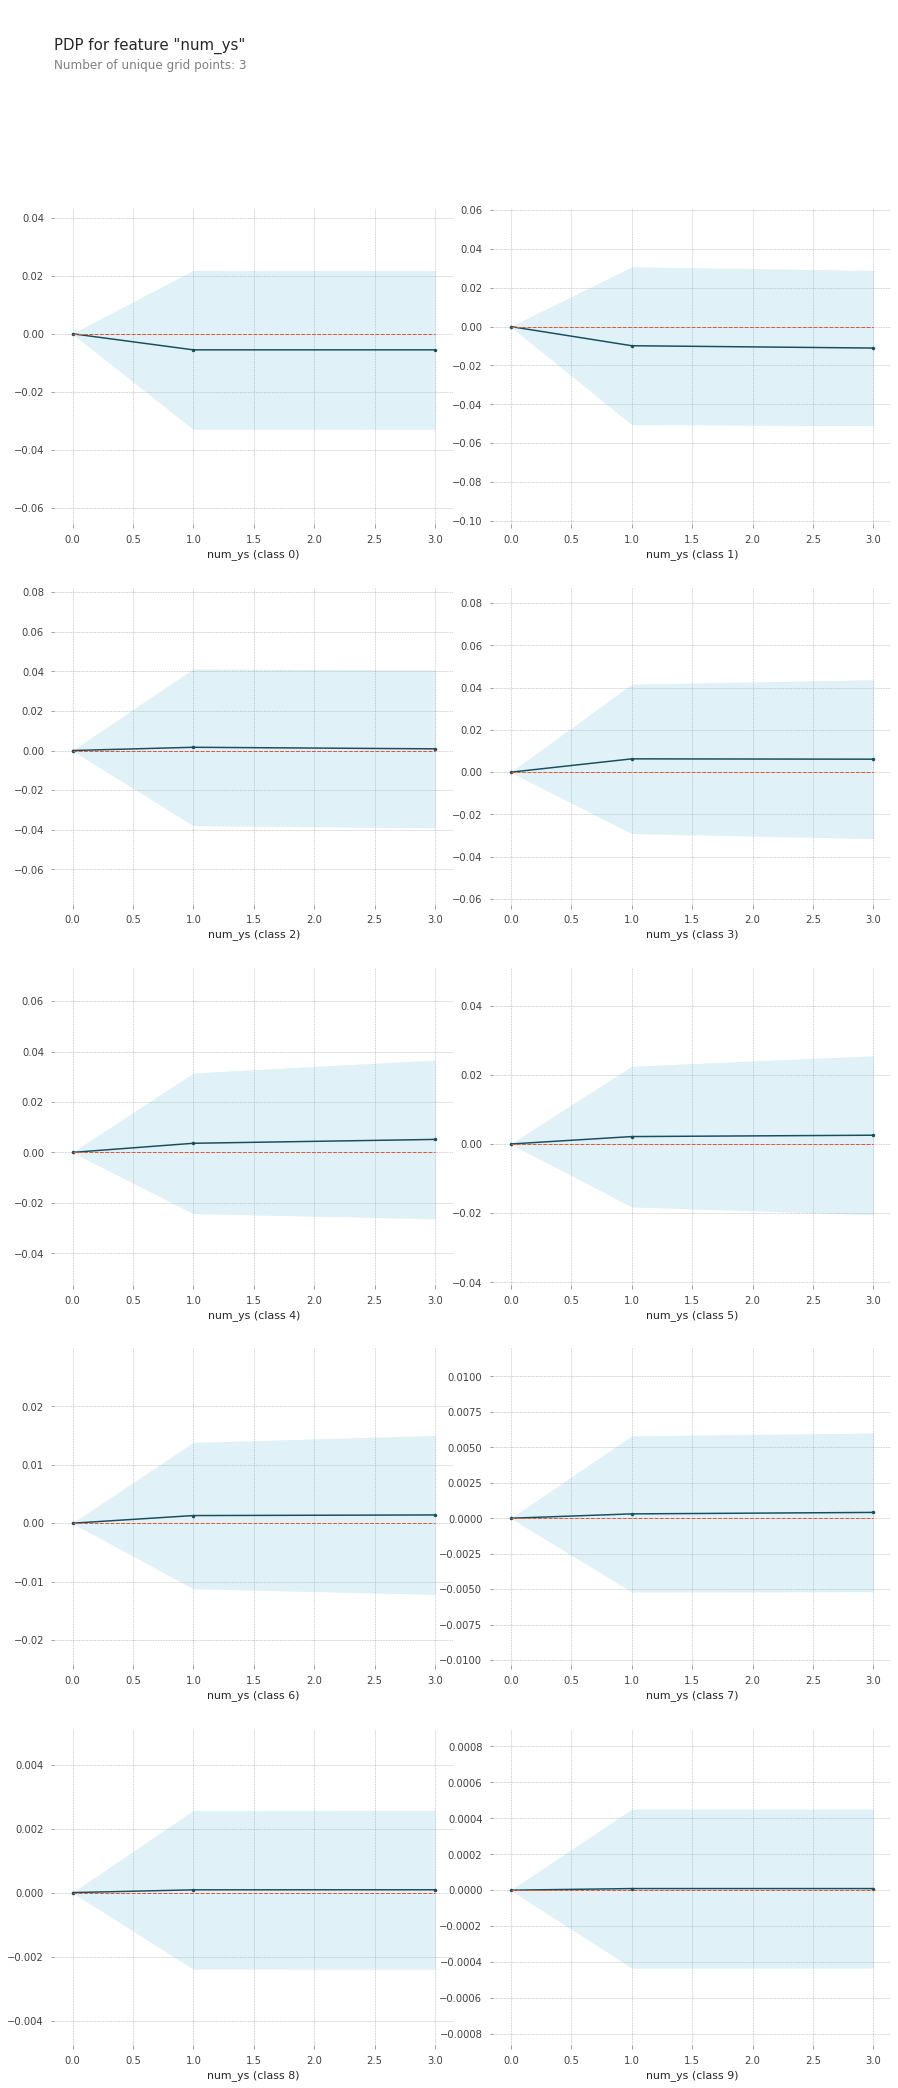

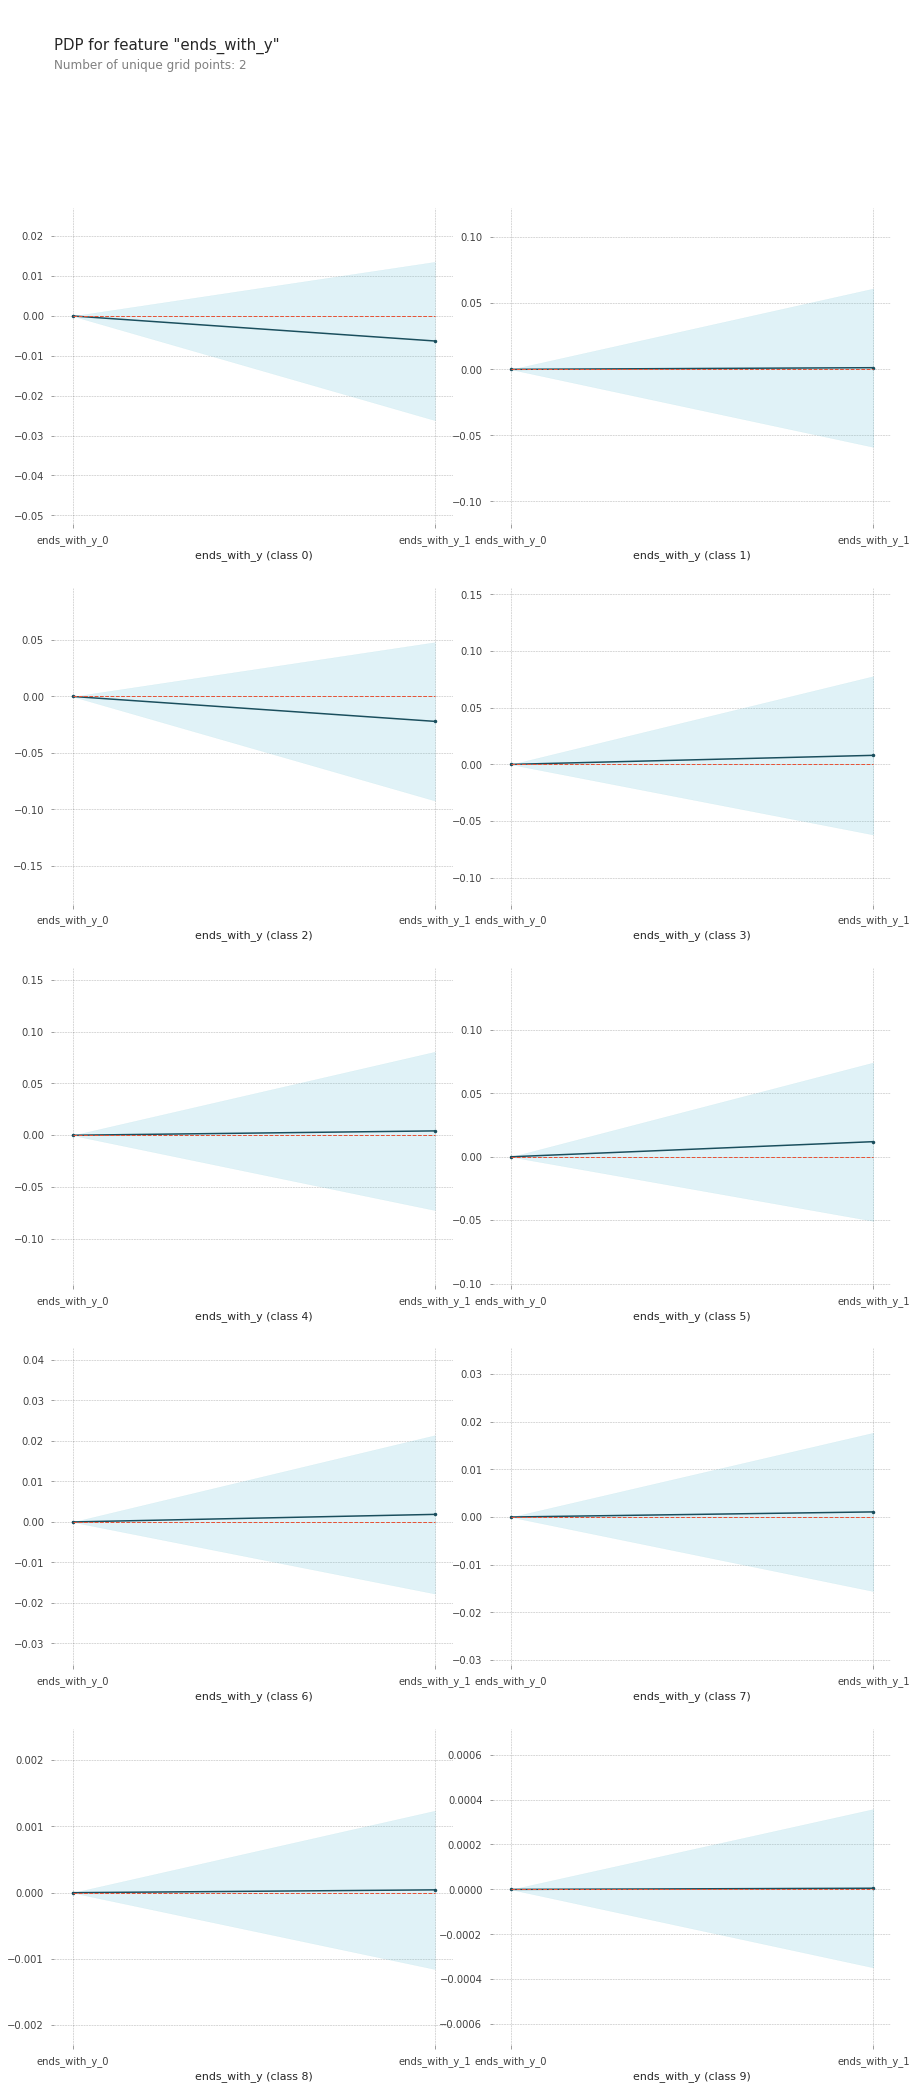

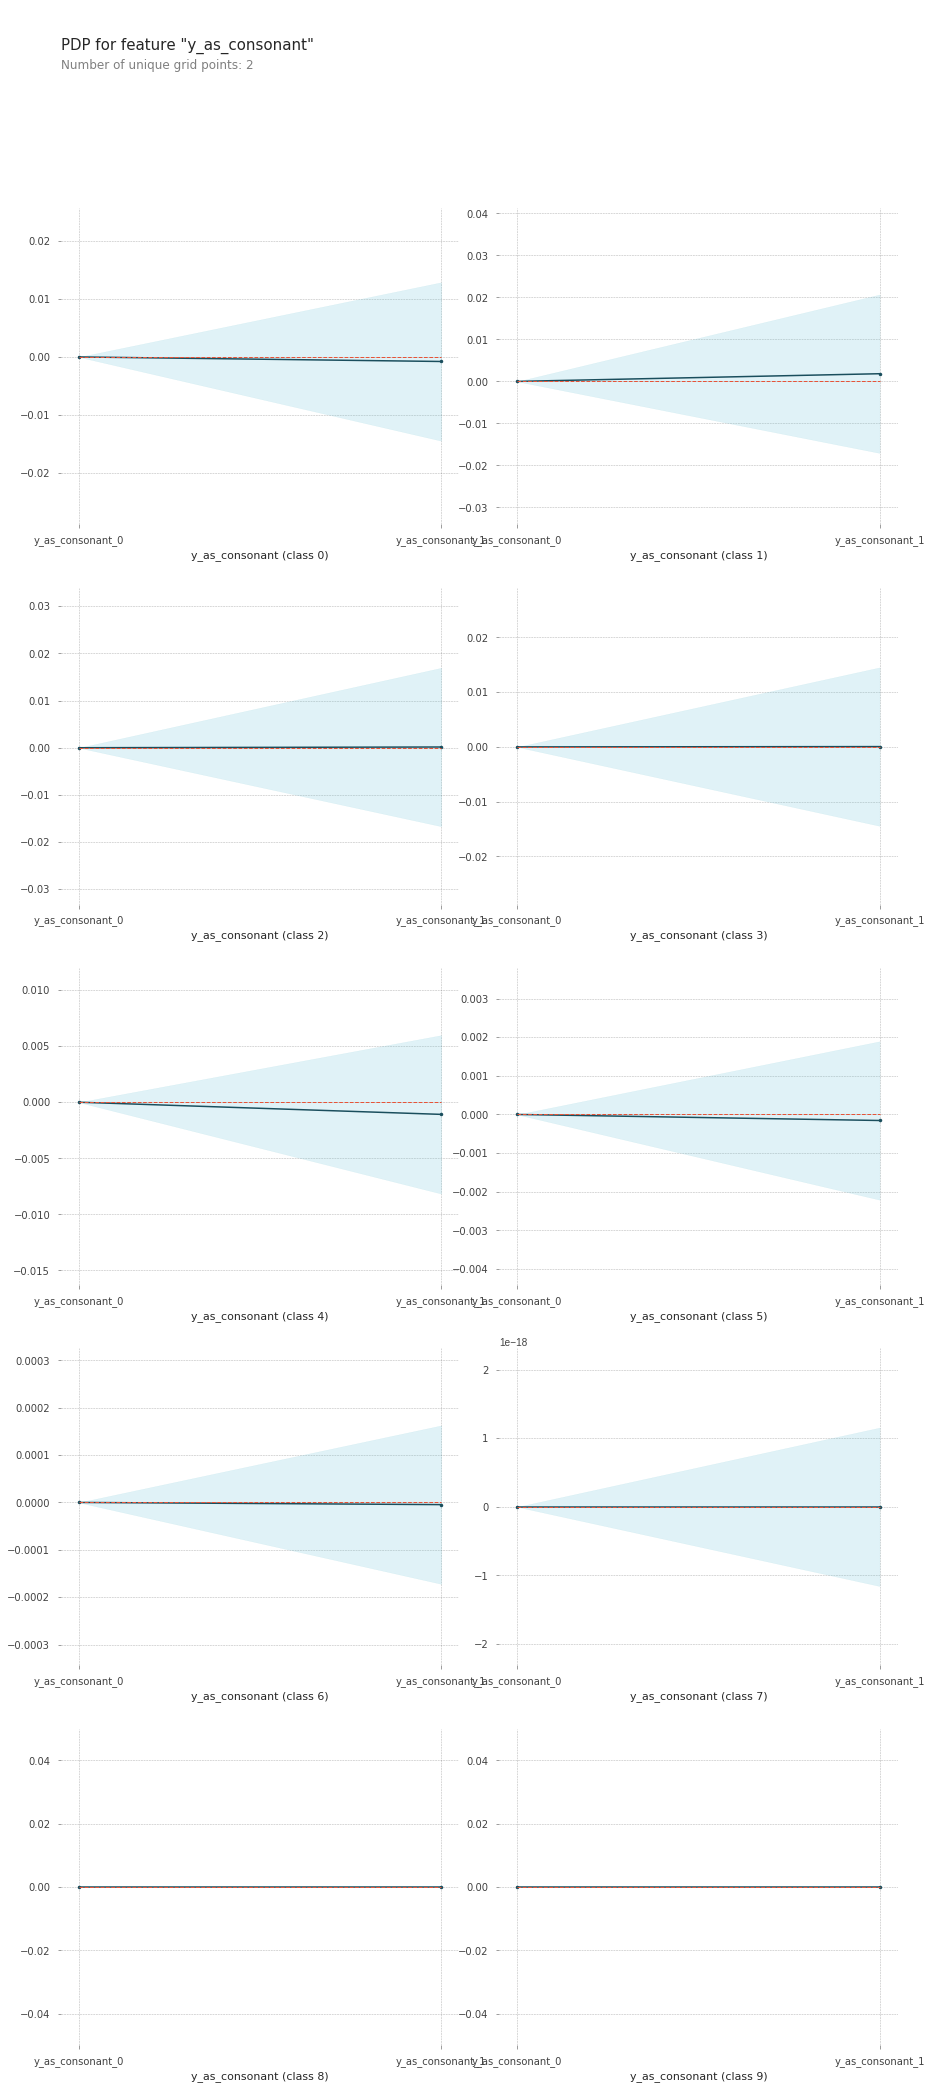

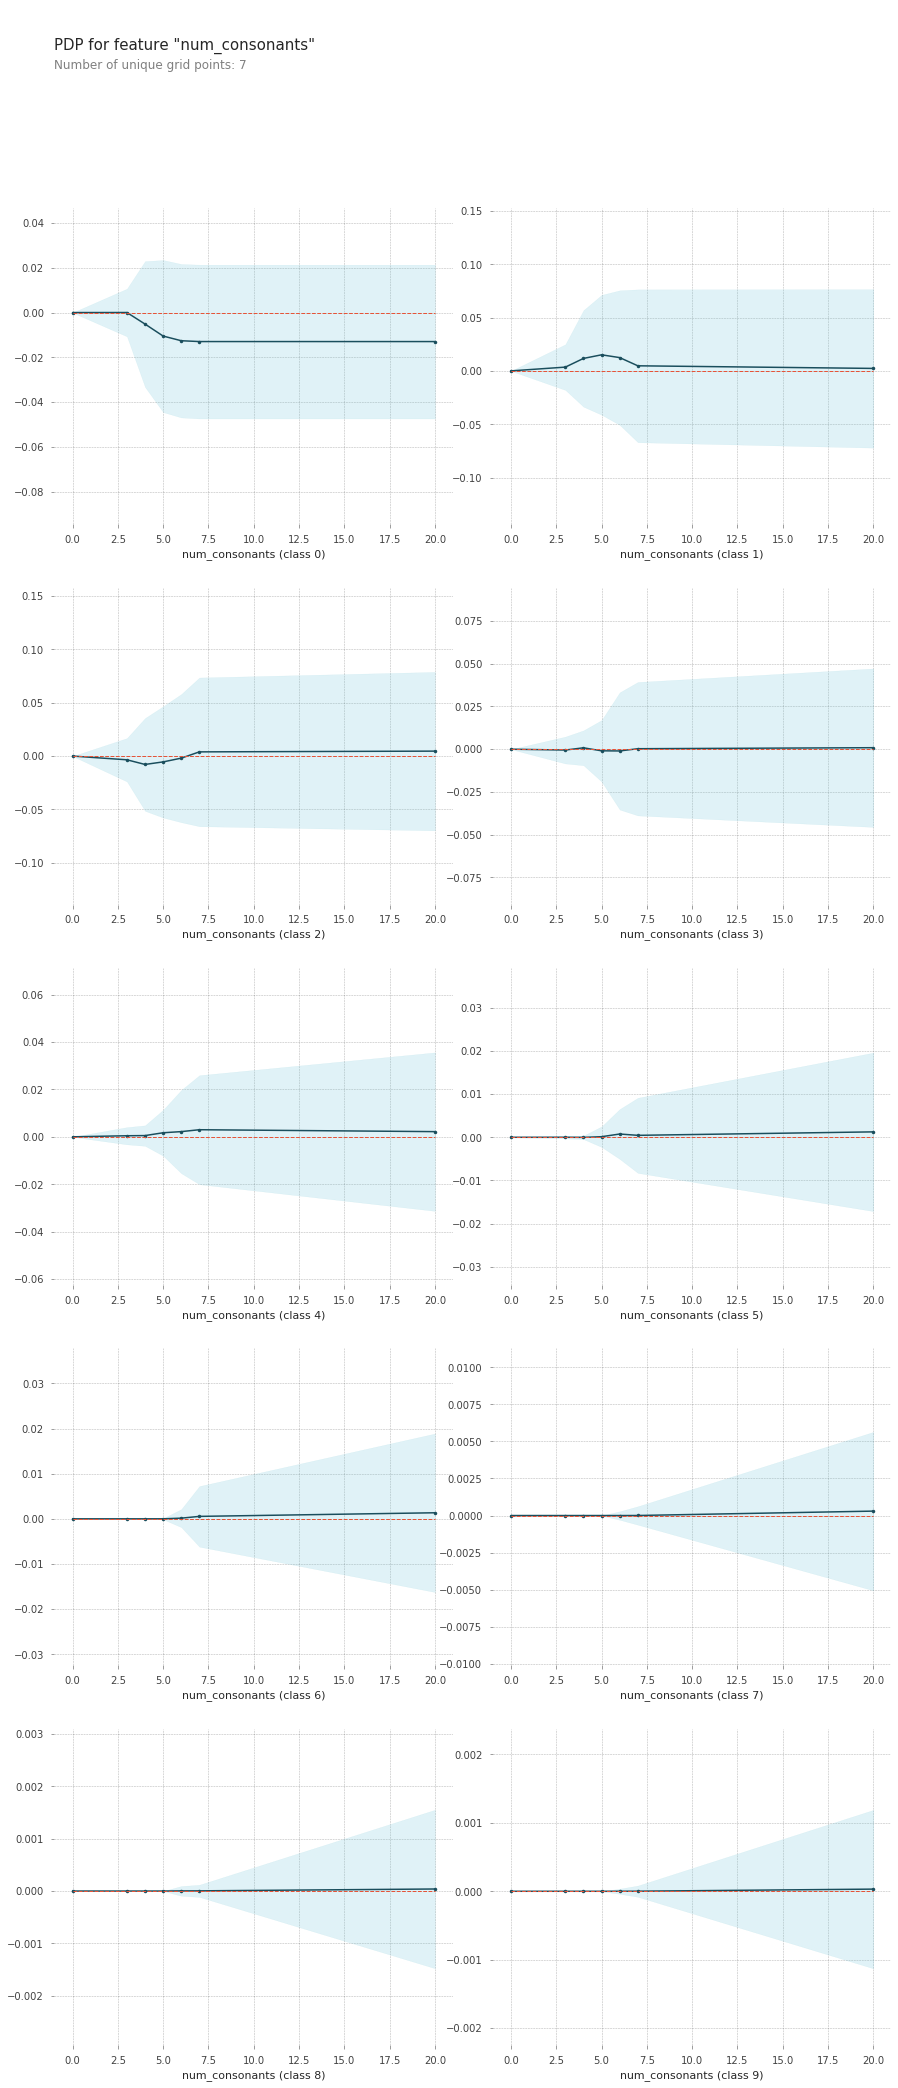

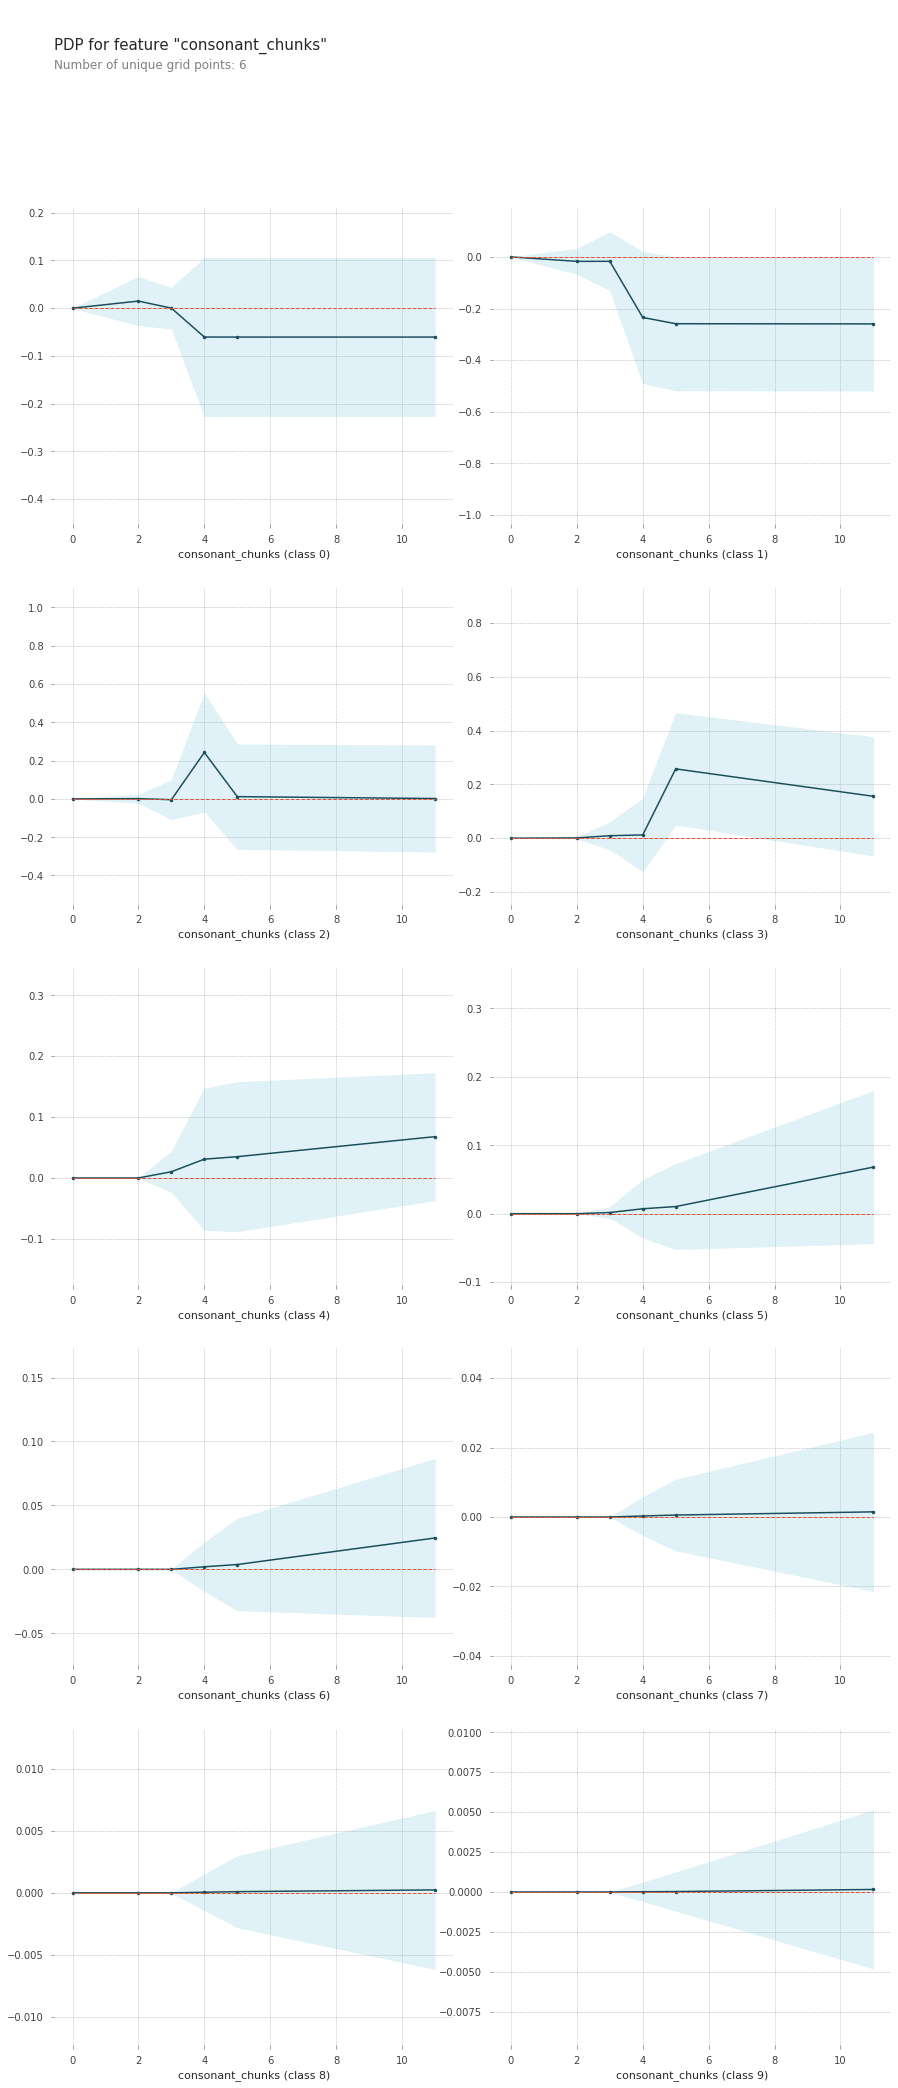

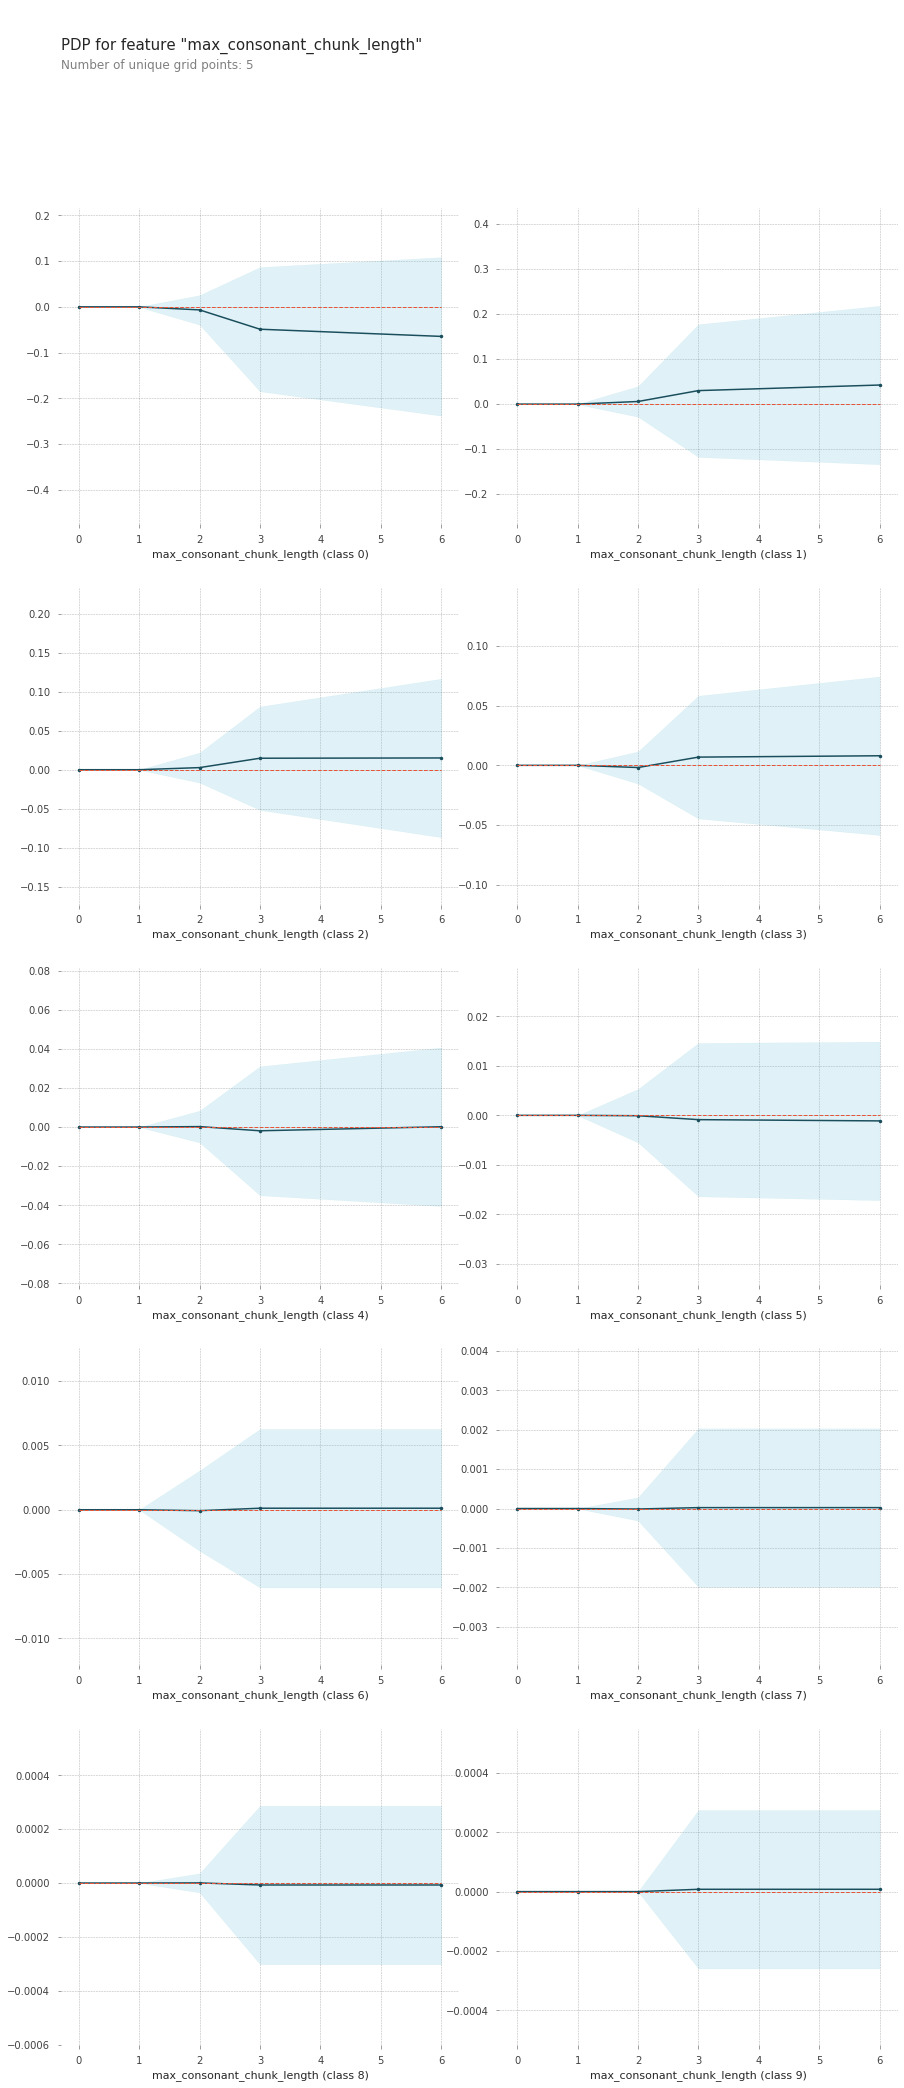

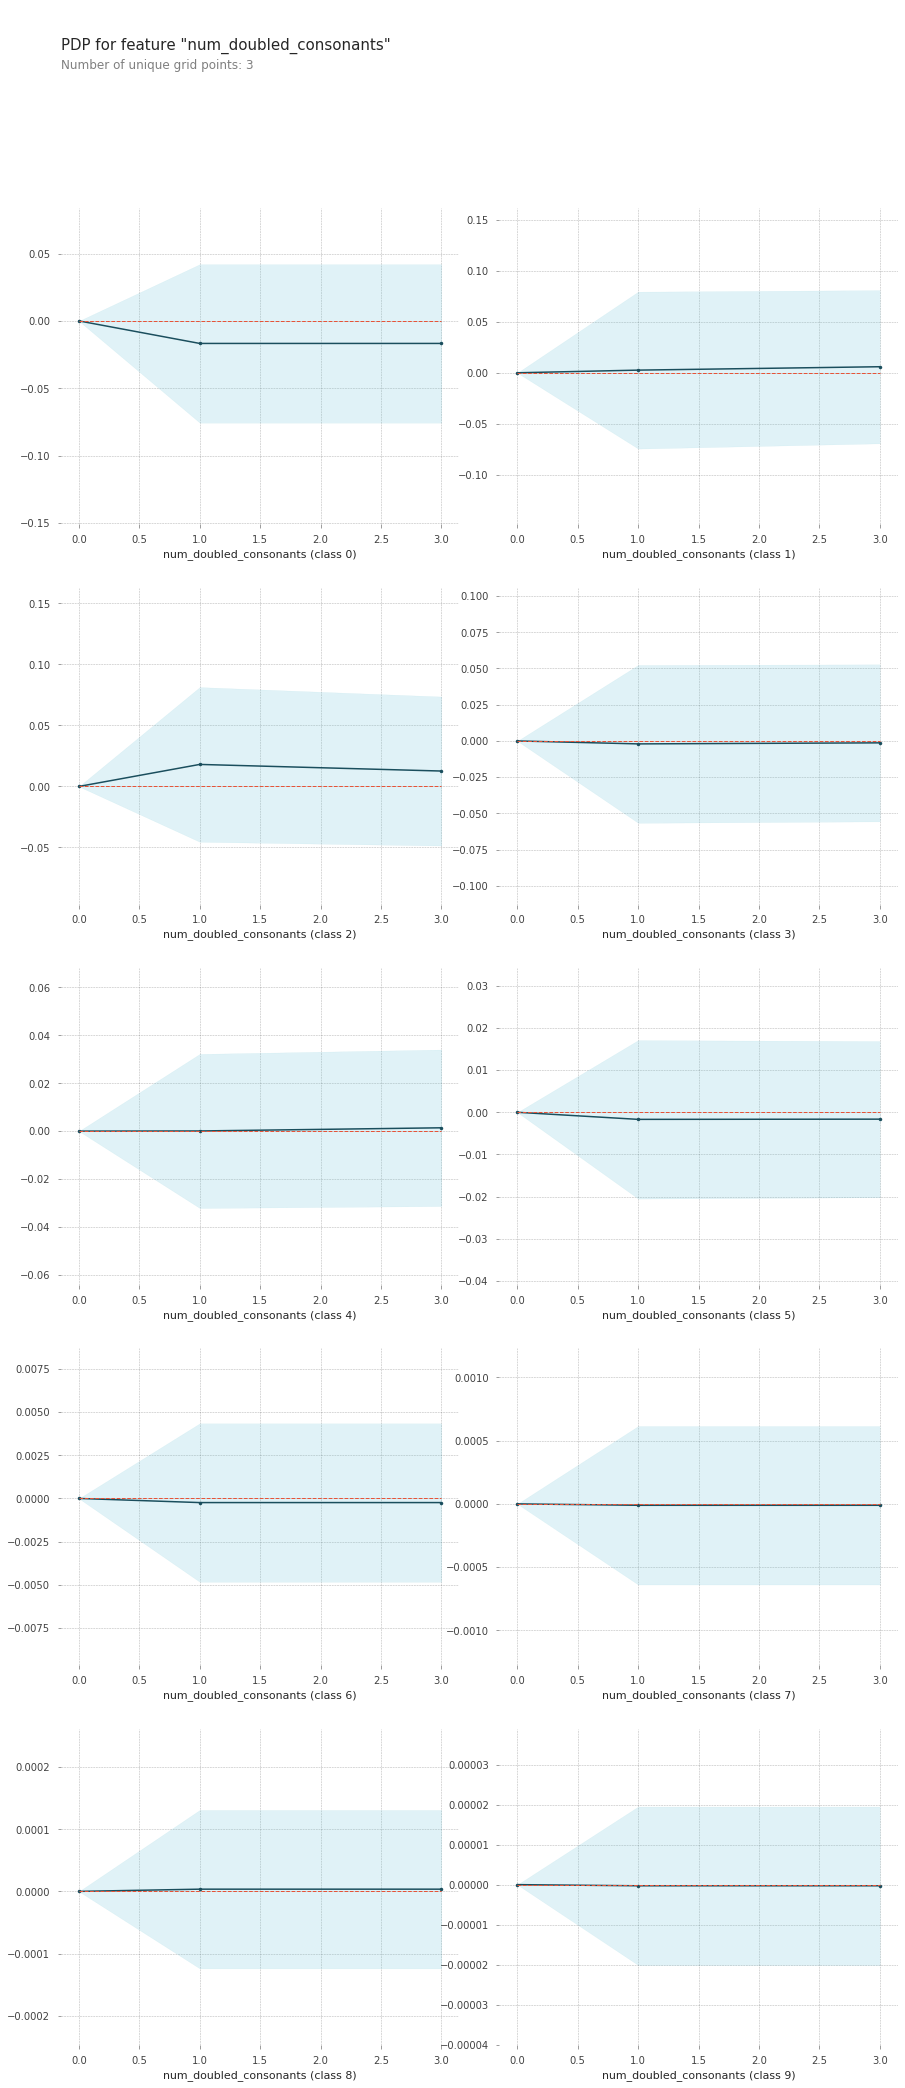

In [31]:
from pdpbox.pdp import pdp_isolate, pdp_plot, pdp_interact, pdp_interact_plot

for feature in features:
  isolated = pdp_isolate(model=model, dataset=X_test, model_features=features, feature=feature)
  pdp_plot(isolated, feature_name=feature)

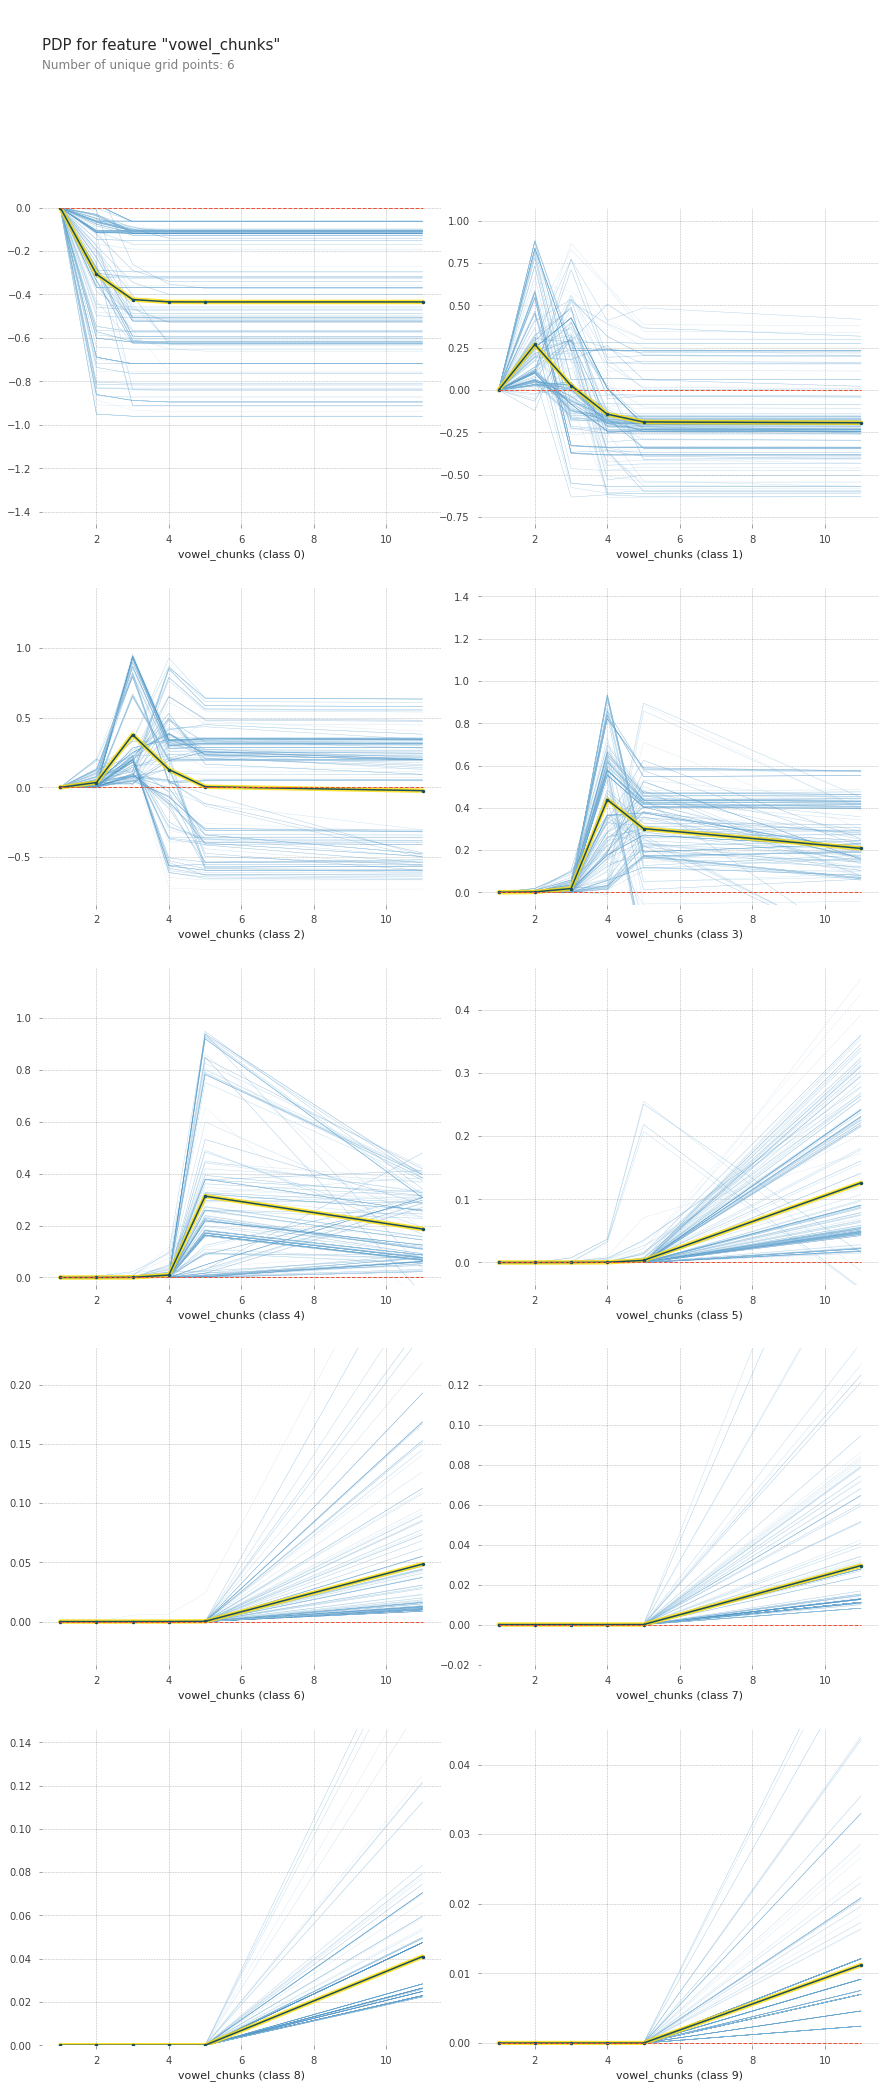

In [36]:
isolated2 = pdp_isolate(model, X_test, features, 'vowel_chunks')
pdp_plot(isolated2, 'vowel_chunks', plot_lines=True, frac_to_plot=0.01);

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


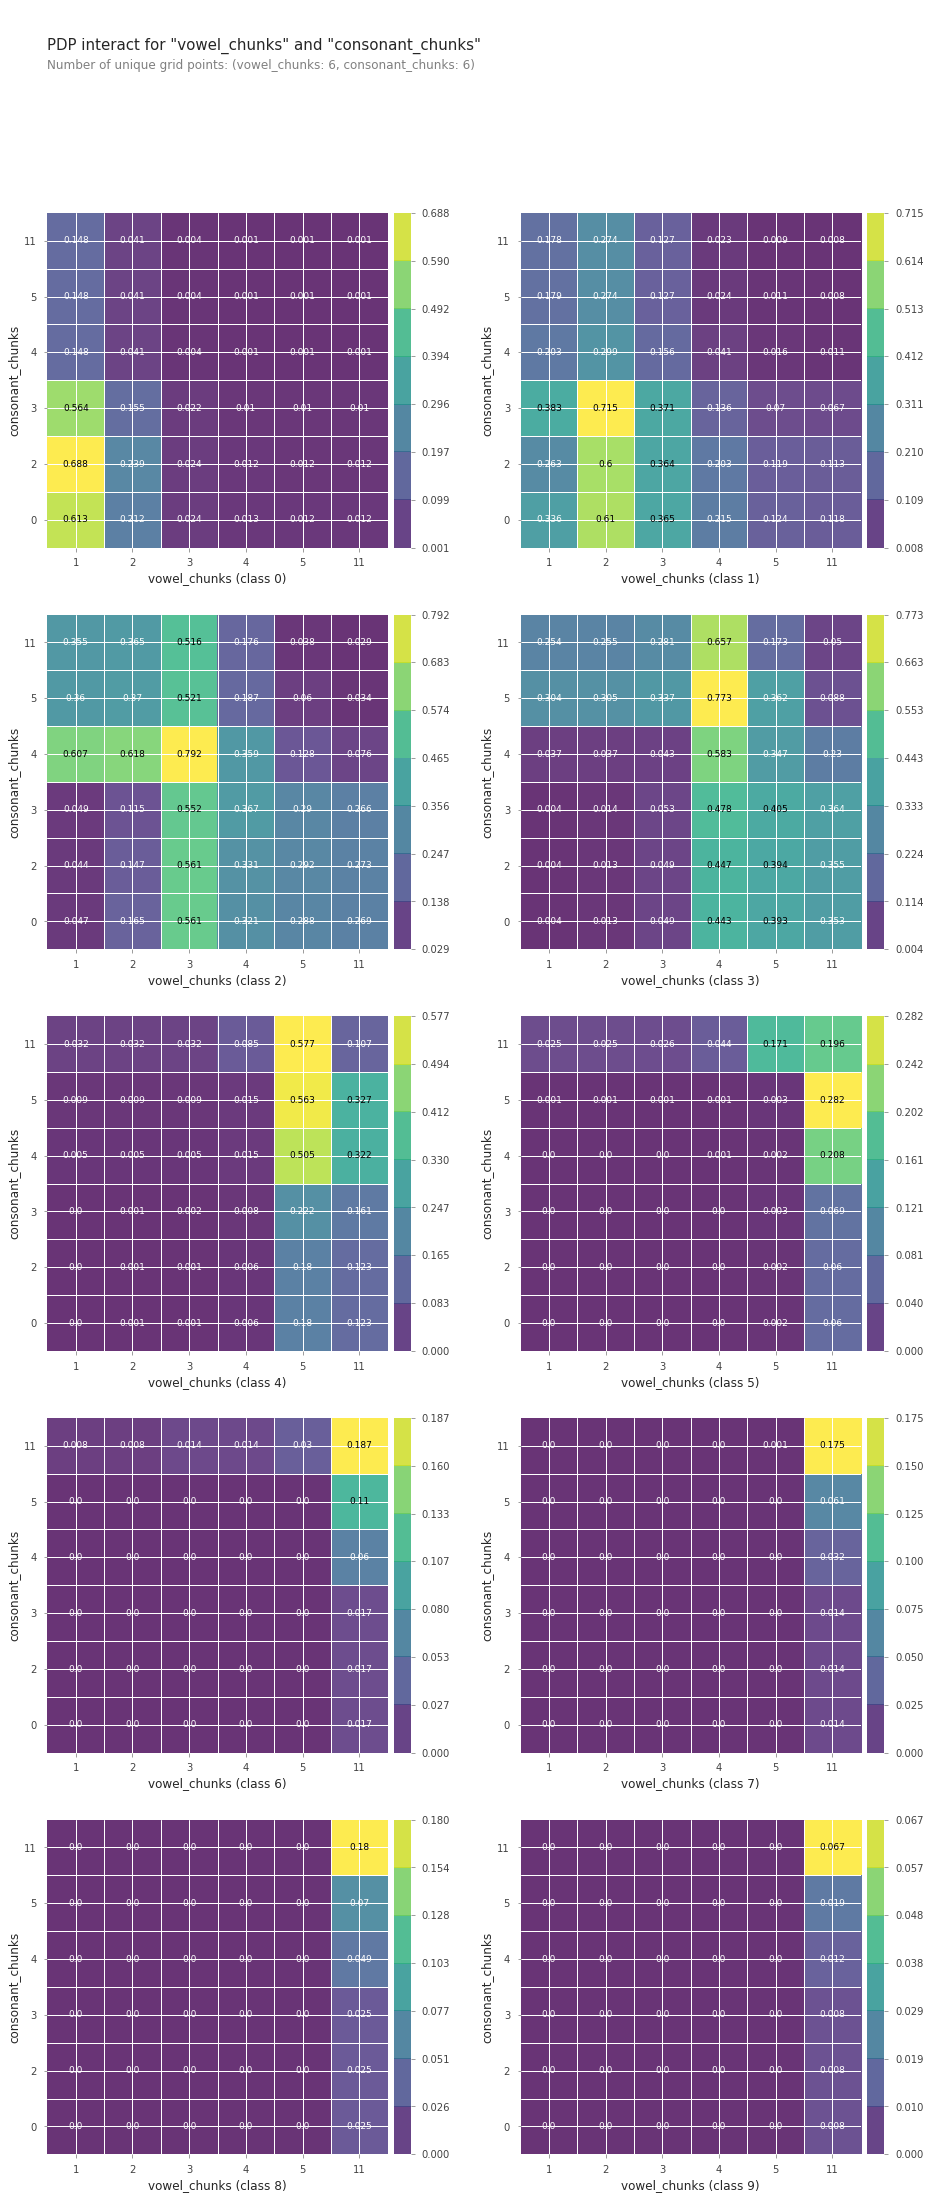

In [37]:
interact_features = ['vowel_chunks', 'consonant_chunks']
interaction = pdp_interact(model=model, dataset=X_test, model_features=features, features=interact_features)
pdp_interact_plot(interaction, interact_features, 'grid');

In [38]:
features

Index(['length', 'num_vowels', 'vowel_chunks', 'max_vowel_chunk_length',
       'ends_with_e', 'h_as_vowel', 'num_ys', 'ends_with_y', 'y_as_consonant',
       'num_consonants', 'consonant_chunks', 'max_consonant_chunk_length',
       'num_doubled_consonants'],
      dtype='object')

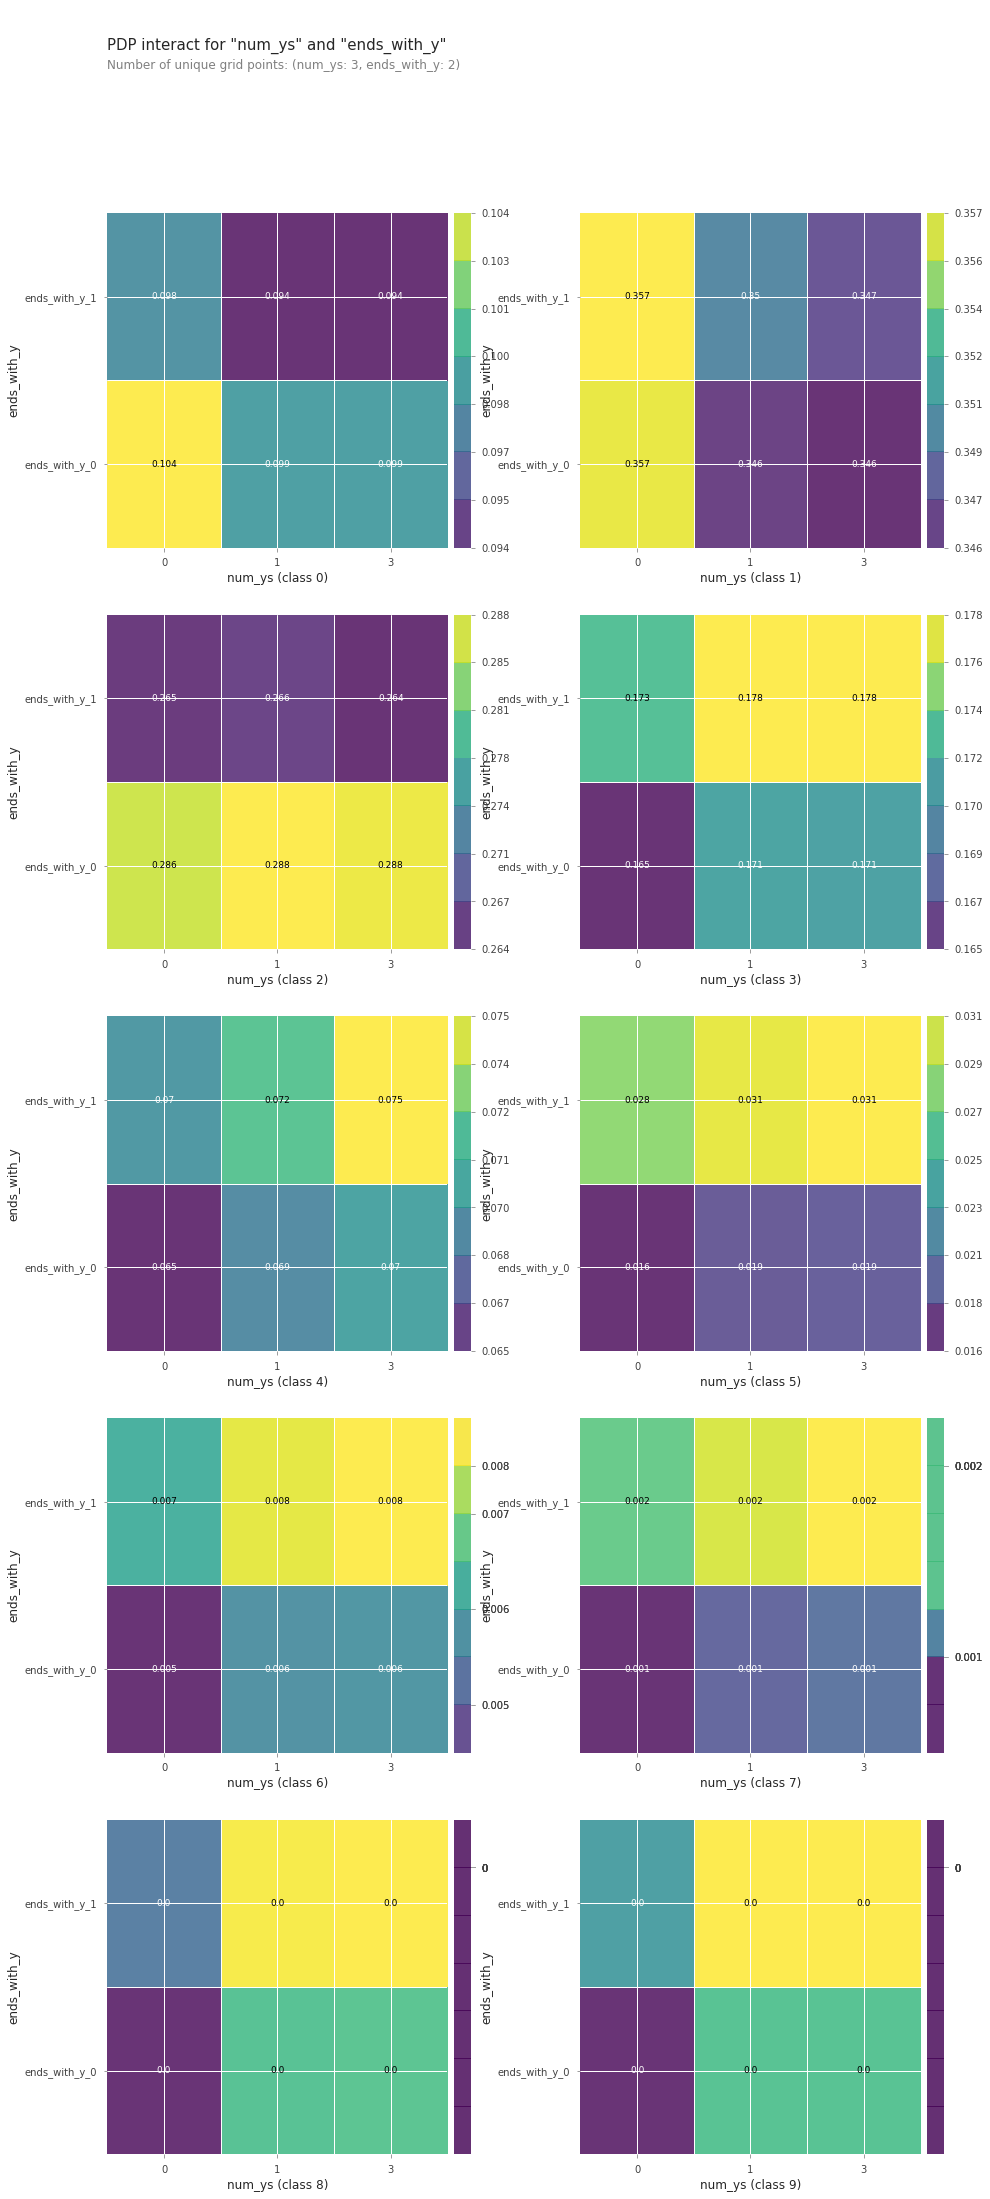

In [41]:
interact_features = ['num_ys', 'ends_with_y']
interaction = pdp_interact(model=model, dataset=X_test, model_features=features, features=interact_features)
pdp_interact_plot(interaction, interact_features, 'grid');

In [43]:
row = X_test.iloc[[2345]]
row

length  num_vowels  ...  max_consonant_chunk_length  num_doubled_consonants
53614       7           2  ...                           2                       1

[1 rows x 13 columns]

In [44]:
syl = y1_test.iloc[[2345]]
syl

53614    2
Name: syllables, dtype: int64

In [46]:
entry = df_test.iloc[[2345]]
entry['entry']

53614    pollock
Name: entry, dtype: object

In [45]:
model.predict(row)

array([2])

In [48]:
import shap

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(row)

shap_values

[array([[-1.77543888e-02,  9.81643355e-03, -2.09079394e-02,
         -2.79418401e-02, -2.41125002e-02,  1.23499694e-05,
          1.19020921e-03,  9.02146606e-04,  1.02403803e-04,
         -1.08027500e-02,  1.17252497e-02,  8.31168567e-03,
         -7.02951200e-03]]),
 array([[ 1.50579660e-02,  7.71855927e-02,  3.23098367e-01,
         -1.33238962e-02, -1.00726122e-02,  2.99415763e-06,
          1.30224788e-03,  1.73302191e-05, -1.02614669e-04,
          8.42393298e-03,  1.98545646e-01,  3.65213596e-03,
          2.67486431e-03]]),
 array([[ 9.29008017e-03, -5.69316527e-02, -1.42490674e-01,
          1.86508004e-02,  1.31153144e-02, -1.65259639e-05,
         -1.62653438e-03,  5.30623038e-04,  3.87050995e-06,
          2.73011711e-03, -1.17092478e-01, -1.04887462e-02,
          5.62032517e-03]]),
 array([[-1.57373384e-03, -2.31304429e-02, -1.04799090e-01,
          1.23584809e-02,  1.32897779e-02,  1.17860679e-06,
         -2.88473682e-04, -4.40114108e-04, -5.74830883e-05,
          3.80771132e-04, -5.50680162e-02, -1.56249194e-03,
         -8.02748281e-04]]),
 array([[-3.09771907e-03, -5.42531187e-03, -4.17343520e-02,
          7.04873609e-03,  6.41448951e-03,  3.23006993e-09,
         -2.16994921e-04, -3.47284610e-04,  4.85115817e-05,
         -2.32231174e-04, -2.78462369e-02,  6.71445373e-05,
          3.05782065e-05]]),
 array([[-1.20741616e-03, -1.13049575e-03, -1.01888532e-02,
          2.59501162e-03,  1.03029559e-03,  0.00000000e+00,
         -2.01637262e-04, -5.33983726e-04,  5.13898934e-06,
         -1.76356007e-04, -7.79581994e-03,  2.81631199e-05,
         -4.37902497e-04]]),
 array([[-5.08254651e-04, -2.75538512e-04, -2.40975530e-03,
          6.01265896e-04,  3.05937112e-04,  0.00000000e+00,
         -1.19376636e-04, -6.59265444e-05,  1.72873078e-07,
         -2.61306264e-04, -1.99092094e-03, -4.87348153e-06,
         -5.50025546e-05]]),
 array([[-1.53044845e-04, -7.93370612e-05, -4.29393563e-04,
          1.26482848e-05,  2.42935858e-05,  0.00000000e+00,
         -2.78227162e-05, -6.19460495e-05,  0.00000000e+00,
         -4.74447437e-05, -3.64336940e-04, -3.24496436e-06,
         -1.45418010e-06]]),
 array([[-3.15849993e-05, -1.69435199e-05, -1.00562754e-04,
         -8.52589492e-07,  1.18166721e-06,  0.00000000e+00,
         -9.73304633e-06, -9.26018379e-07,  0.00000000e+00,
         -8.89927223e-06, -8.07661402e-05,  7.55369395e-07,
          9.09986983e-07]]),
 array([[-2.19038108e-05, -1.23039862e-05, -3.77467483e-05,
         -3.54264955e-07,  3.82268726e-06,  0.00000000e+00,
         -1.88444207e-06,  8.11926988e-08,  0.00000000e+00,
         -5.83374359e-06, -3.23203422e-05, -5.28099805e-07,
         -5.81676721e-08]])]

In [53]:
len(shap_values)

10

In [63]:
shap.initjs()

for i in range(0, len(shap_values)):
  display(shap.force_plot(base_value=explainer.expected_value[i], shap_values=shap_values[i], features=row, feature_names=features, out_names=f'syllables == {i+1}'))


In [61]:
explainer.expected_value

array([1.03322300e-01, 3.58016641e-01, 2.87393037e-01, 1.61692386e-01,
       6.52906674e-02, 1.80138552e-02, 4.78357900e-03, 1.13108319e-03,
       2.47421317e-04, 1.09029726e-04])

In [62]:
explainer.expected_value.max()

0.3580166410627196

In [64]:
y1_test[y1_test > 5]

139572    6
60482     6
39518     6
39519     6
136902    6
         ..
16302     6
1296      7
34993     6
59307     6
40500     6
Name: syllables, Length: 451, dtype: int64

In [66]:
y1_test.shape

(18480,)

In [67]:
y1_test.loc[[60482]]

60482    6
Name: syllables, dtype: int64

In [68]:
X_test.loc[[60482]]

length  num_vowels  ...  max_consonant_chunk_length  num_doubled_consonants
60482      14           5  ...                           2                       1

[1 rows x 13 columns]

In [69]:
df_test.loc[[60482]]

entry  ... num_doubled_consonants
60482  recommendatory  ...                      1

[1 rows x 17 columns]

In [74]:
row = X_test.loc[[60482]]
syl = y1_test.loc[[60482]]
entry = df_test.loc[[60482]]

print('row')
display(row)
print('syl')
display(syl)
print('entry')
display(entry)

row


length  num_vowels  ...  max_consonant_chunk_length  num_doubled_consonants
60482      14           5  ...                           2                       1

[1 rows x 13 columns]

syl


60482    6
Name: syllables, dtype: int64

entry


entry  ... num_doubled_consonants
60482  recommendatory  ...                      1

[1 rows x 17 columns]

In [75]:
model.predict(row)

array([6])

In [77]:
shap.initjs()

shap_values = explainer.shap_values(row)

for i in range(0, len(shap_values)):
  display(shap.force_plot(base_value=explainer.expected_value[i], shap_values=shap_values[i], features=row, feature_names=features, out_names=f'syllables == {i+1}'))

In [0]:
def predict(word:str):
  if (df_words['entry']==word).any():
    display(HTML(f'<h3>I know the word: {word}</h3>'))
    display(df_words[df_words['entry']=='atrium'])
    display(HTML('<br><hr><br>'))

  row = engineer_word_features(word)
  display(HTML(f'<h3>{word}</h3>'))
  display(row)
  display(HTML('<br><hr><br>'))

  predicted_syllables = model.predict(row)
  display(HTML(f'<h3>Predicted syllables: {predicted_syllables[0]}</h3>'))

  shap.initjs()
  shap_values = explainer.shap_values(row)
  for i in range(0, len(shap_values)):
    if i + 1 == predicted_syllables[0]:
      display(HTML('<hr>'))
    display(shap.force_plot(base_value=explainer.expected_value[i], shap_values=shap_values[i], features=row, feature_names=features, out_names=f'predicted syllables = {i+1}'))
    if i + 1 == predicted_syllables[0]:
      shaps = pd.Series(shap_values[i][0], [f'{feature} = {value}' for feature, value in zip(features, row.values[0])])
      shaps_df = shaps.to_frame()
      shaps_df.columns = ['shap_values']
      display(HTML(shaps_df.to_html()))
      display(HTML('<hr>'))
    

  return

In [134]:
print(predict('atrium'))

entry entry_rich  ...  max_consonant_chunk_length num_doubled_consonants
71203  atrium   a·tri·um  ...                           2                      0

[1 rows x 17 columns]

length  num_vowels  ...  max_consonant_chunk_length  num_doubled_consonants
atrium       6           3  ...                           2                       0

[1 rows x 13 columns]

None


In [82]:
df_words[df_words['entry']=='atrium']

entry entry_rich  ...  max_consonant_chunk_length num_doubled_consonants
71203  atrium   a·tri·um  ...                           2                      0

[1 rows x 17 columns]

In [113]:
row.values[0]

array([14, 5, 6, 1, False, False, 1, True, False, 9, 6, 2, 1],
      dtype=object)

In [115]:
len(shap_values[5])

1

In [116]:
shap_values

[array([[-1.00561195e-02, -6.91219715e-03, -3.70096080e-02,
         -6.73729497e-03, -5.89962474e-03, -1.18810403e-06,
         -9.99969430e-04, -1.54164024e-03,  7.19854834e-05,
         -4.99121643e-03, -2.76531195e-02,  2.33647815e-03,
         -3.92878563e-03]]),
 array([[-1.04167029e-02, -2.63186411e-02, -1.65011734e-01,
         -2.58123703e-02, -1.10089742e-02,  8.53508583e-07,
         -4.12621377e-03, -1.04379070e-03, -4.38242121e-05,
         -2.94425052e-03, -1.08651072e-01, -1.34260478e-03,
         -1.29731569e-03]]),
 array([[-4.18570747e-03, -1.43553890e-02, -1.50652717e-01,
          6.37095751e-04, -1.63914407e-02, -8.77128450e-08,
         -1.74165593e-03, -8.20721193e-03, -4.87214563e-05,
          1.03409401e-03, -1.00642956e-01, -4.00378329e-04,
          7.56203878e-03]]),
 array([[-1.28939015e-03,  6.60496615e-03, -9.33677134e-02,
          1.49009312e-02,  1.57775130e-02,  4.18672474e-07,
         -1.04857223e-03, -4.87928723e-03, -2.58180203e-04,
          2.58431782e-03, -1.01764698e-01, -7.11953867e-04,
          1.75926210e-03]]),
 array([[-1.83933834e-03,  1.43051089e-02,  5.38222898e-02,
         -7.95583418e-02, -2.21093969e-02,  3.63582166e-09,
         -7.46213327e-03, -7.02851331e-02,  8.22084733e-05,
         -1.56530854e-04,  5.02479965e-02,  2.21010776e-04,
          1.76983865e-03]]),
 array([[ 2.63040550e-02,  3.04680256e-02,  4.21351393e-01,
          9.42837018e-02,  3.74445644e-02,  0.00000000e+00,
          1.43906841e-02,  8.10244939e-02,  1.90058293e-04,
          4.53821699e-03,  2.70903572e-01,  1.49325018e-04,
         -5.68202092e-03]]),
 array([[ 1.86663140e-03, -3.46935840e-03, -2.32943285e-02,
          2.28350490e-03,  2.03309497e-03,  0.00000000e+00,
          5.72448477e-04,  3.58770618e-03,  6.47362223e-06,
         -1.39997710e-04,  1.44745353e-02, -2.25885511e-04,
         -1.86577896e-04]]),
 array([[-2.72499419e-04, -2.97634990e-04, -5.09499910e-03,
         -1.32368918e-06,  1.32535108e-04,  0.00000000e+00,
          3.64108807e-04,  1.32428414e-03,  0.00000000e+00,
          9.88490838e-05,  2.63784682e-03, -2.37379337e-05,
          1.48798162e-06]]),
 array([[-6.63334185e-05, -9.76488926e-06, -6.16216140e-04,
          6.10656096e-06,  1.17579622e-05,  0.00000000e+00,
          4.32759737e-05,  2.05991062e-05,  0.00000000e+00,
         -1.75989632e-05,  3.77495573e-04,  1.06864112e-06,
          2.18827667e-06]]),
 array([[-4.45952241e-05, -1.51151058e-05, -1.26366030e-04,
         -2.00932933e-06,  9.97105906e-06,  0.00000000e+00,
          8.02728810e-06, -2.01227960e-08,  0.00000000e+00,
         -5.88342452e-06,  7.03989753e-05, -3.32216399e-06,
         -1.15647116e-07]])]

In [121]:
pd.Series(shap_values[0][0], zip(features, row.values[0]))

(length, 14)                      -0.010056
(num_vowels, 5)                   -0.006912
(vowel_chunks, 6)                 -0.037010
(max_vowel_chunk_length, 1)       -0.006737
(ends_with_e, False)              -0.005900
(h_as_vowel, False)               -0.000001
(num_ys, 1)                       -0.001000
(ends_with_y, True)               -0.001542
(y_as_consonant, False)            0.000072
(num_consonants, 9)               -0.004991
(consonant_chunks, 6)             -0.027653
(max_consonant_chunk_length, 2)    0.002336
(num_doubled_consonants, 1)       -0.003929
dtype: float64

In [120]:
explainer.expected_value

array([1.03322300e-01, 3.58016641e-01, 2.87393037e-01, 1.61692386e-01,
       6.52906674e-02, 1.80138552e-02, 4.78357900e-03, 1.13108319e-03,
       2.47421317e-04, 1.09029726e-04])

In [123]:
[f'{feature} = {value}' for feature, value in zip(features, row.values[0])]

['length = 14',
 'num_vowels = 5',
 'vowel_chunks = 6',
 'max_vowel_chunk_length = 1',
 'ends_with_e = False',
 'h_as_vowel = False',
 'num_ys = 1',
 'ends_with_y = True',
 'y_as_consonant = False',
 'num_consonants = 9',
 'consonant_chunks = 6',
 'max_consonant_chunk_length = 2',
 'num_doubled_consonants = 1']

In [130]:
display(pd.Series(shap_values[0][0], zip(features, row.values[0])))

(length, 14)                      -0.010056
(num_vowels, 5)                   -0.006912
(vowel_chunks, 6)                 -0.037010
(max_vowel_chunk_length, 1)       -0.006737
(ends_with_e, False)              -0.005900
(h_as_vowel, False)               -0.000001
(num_ys, 1)                       -0.001000
(ends_with_y, True)               -0.001542
(y_as_consonant, False)            0.000072
(num_consonants, 9)               -0.004991
(consonant_chunks, 6)             -0.027653
(max_consonant_chunk_length, 2)    0.002336
(num_doubled_consonants, 1)       -0.003929
dtype: float64